## Анализ влияния детализации зонирования мозга на точность классификации шизофрении

**Данные для 100 человек (46 больных и 54 нормы).**

**Каждый файл с сегментацией имеет различные и общую части:**

* Различные части - сегментация коры различными методами.
* Общая часть - сегментация подкоркового вещества (60 ROI cо значениями объемов)


  Атлас         | Сегментация коры |Число признаков
  ------------- | -----------------|----------------
  Desikan       | 34 ROI           | 269
  Destrieux     | 74 ROI           | 509
  Yeo7          | 7 ROI            | 113
  Yeo17         | 17 ROI           | 173

  **Задачи**:
  1. Выяснить, влияет ли детализация зонирования на точность классификации (атласы Desikan, Destrieux)
  +  Оценить значимость зон из префронтальной коры (атласы Desikan, Destrieux)
  *  Базовые эксперименты для атласов Yeo7 и Yeo17
  4. Выявить людей, не поддающихся классификации
  5. Найти зоны, которые наилучшим образом разделяют выборку

### Импортируем библиотеки и необходимые инструменты

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()
%matplotlib inline

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import recall_score, precision_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from collections import OrderedDict
from operator import itemgetter
from sklearn.decomposition import PCA
from sklearn.base import clone
import itertools
import time

In [6]:
def get_features(fname):
    X = pd.read_excel(fname, index_col='Unnamed: 1', skiprows=2)
    X = X.iloc[1:, :]
    X.drop('Unnamed: 0', axis=1, inplace=True)
    return X

def get_target(X):
    return np.array(['SCH' in idx for idx in X.index])

### Считаем данные

In [7]:
atlases = ['Desikan','Destrieux','Yeo7Networks','Yeo17Networks']
destr = 'Destrieux'
desik = 'Desikan'
yeo7 = 'Yeo7Networks'
yeo17 = 'Yeo17Networks'
des_checked = 'Desikan_quality_checked'
X = {}
y = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}

for atlas in atlases:
    X[atlas] = get_features('./data/MHRC_data_sch_'+atlas+'.xlsx')
    y[atlas] = get_target(X[atlas])
    X_train[atlas], X_test[atlas], y_train[atlas], y_test[atlas] = train_test_split(X[atlas], y[atlas], 
                                                                            test_size=0.33, random_state=42, stratify = y[atlas])

### Выделим для атласов Desikan и Destrieux признаки, относящиеся к префронтальной коре

In [8]:
frontal_columns = {}
frontal_columns_like = {}
frontal_columns_like['Desikan'] = [
'_caudalmiddlefrontal_',
'_lateralorbitofrontal_',
'_medialorbitofrontal_',
'_parsopercularis_',
'_parsorbitalis_',
'_parstriangularis_',
'_rostralmiddlefrontal_',
'_superiorfrontal_',
'_frontalpole_']

'''frontal_columns_like[des_checked] = [
'_caudalmiddlefrontal_',
'_lateralorbitofrontal_',
'_medialorbitofrontal_',
'_parsopercularis_',
'_parsorbitalis_',
'_parstriangularis_',
'_rostralmiddlefrontal_',
'_superiorfrontal_',
'_frontalpole_']'''

frontal_columns_like['Destrieux'] = [
"_G_and_S_frontomargin_",
"_G_and_S_transv_frontopol_",
"_G_front_inf-Opercular_",
"_G_front_inf-Orbital_",
"_G_front_inf-Triangul_",
"_G_front_middle_",
"_G_front_sup_",
"_G_orbital_",
"_G_rectus_",
"_G_subcallosal_",
"_Lat_Fis-ant-Horizont_",
"_Lat_Fis-ant-Vertical_",
"_S_front_inf_",
"_S_front_middle_",
"_S_front_sup_",
"_S_orbital_lateral_",
"_S_orbital-H_Shaped_",
"_S_suborbital_"]

for atlas in ['Desikan', 'Destrieux']:
    frontal_columns[atlas] = [col for col in X[atlas].columns if (any(map(lambda i: frontal_columns_like[atlas][i] in col, 
                                                                          range(len(frontal_columns_like[atlas])))))] 

#### Толщины из префронтальной зоны и из остальных зон

In [9]:
nonfrontal_th_idx = {}
frontal_th_idx = {}
for atlas in [desik, destr]:
    nonfrontal_th_idx[atlas] = [col for col in X[atlas].columns.difference(frontal_columns[atlas]) if ('thick' in col)]
    frontal_th_idx[atlas] = [col for col in frontal_columns[atlas] if ('thick' in col)]

#### Разделение признаков по типу и стандартизация

In [10]:
X_scaled = {}
X_train_scaled = {}
X_test_scaled = {}
X_scaled_pd = {}
all_params = {}
thickness_idx = {}
volume_idx = {}
area_idx = {}

for atlas in atlases:
    scaler = StandardScaler()
    X_scaled[atlas] = scaler.fit_transform(X[atlas])
    X_train_scaled[atlas] = scaler.transform(X_train[atlas])
    X_test_scaled[atlas] = scaler.transform(X_test[atlas])  
    X_scaled_pd[atlas] = pd.DataFrame(data = X_scaled[atlas], columns = X[atlas].columns, index = X[atlas].index)
    all_params[atlas] = X[atlas].columns
    thickness_idx[atlas] = [col for col in X[atlas].columns if 'thickness' in col]
    volume_idx[atlas] = [col for col in X[atlas].columns if 'volume' in col]
    area_idx[atlas] = [col for col in X[atlas].columns if 'area' in col]

### Проведем стат тесты для атласов

In [12]:
import statsmodels.stats.multitest as smm
from scipy.stats import mannwhitneyu as mwu

stats = {}
for atlas in [desik, destr, yeo7, yeo17]:
    params = X[atlas].columns
    pvals = [mwu(X[atlas][par][y[atlas]==0], X[atlas][par][y[atlas]==1]).pvalue for par in params]
    pvals_corr = smm.multipletests(pvals, alpha=0.05, method='bonferroni')[1]
    stats[atlas] = pd.DataFrame(data=np.vstack([pvals_corr]).T, 
                     columns=['p value'],
                     index=params)
    if atlas in [desik, destr]:
        stats[atlas]['Prefrontal'] = [idx in frontal_th_idx[atlas] for idx in stats[atlas].index]

imp_idx = {}
for atlas in [desik, destr, yeo7, yeo17]:
    stats[atlas].sort_values(by='p value', inplace=True)
    imp_idx[atlas] = stats[atlas]['p value']< 1e-3

In [18]:
print('Desikan: cреди первых 13 признаков, по которым выборки значимо различаются, более половины из префронтальной коры')
stats[desik][imp_idx[desik]]

Desikan: cреди первых 13 признаков, по которым выборки значимо различаются, более половины из префронтальной коры


,p value,Prefrontal
rh_MeanThickness_thickness,0.000011,False
lh_MeanThickness_thickness,0.000012,False
rh_lateralorbitofrontal_thickness,0.000034,True
rh_rostralmiddlefrontal_thickness,0.000037,True
lh_superiorfrontal_thickness,0.000047,True
rh_superiorfrontal_thickness,0.000114,True
lh_precuneus_thickness,0.000241,False
rh_superiortemporal_thickness,0.000333,False
rh_parstriangularis_thickness,0.000382,True
lh_superiortemporal_thickness,0.000580,False


In [19]:
print('Destrieux: среди первых 15 признаков, по которым выборки значимо различаются, лишь 3 из префронтальной коры')
stats[destr][imp_idx[destr]]

Destrieux: среди первых 15 признаков, по которым выборки значимо различаются, лишь 3 из префронтальной коры


,p value,Prefrontal
lh_S_circular_insula_sup_thickness,8.063066e-08,False
rh_S_circular_insula_sup_thickness,3.682165e-06,False
rh_S_orbital-H_Shaped_thickness,1.557337e-05,True
lh_S_precentral-sup-part_thickness,1.781638e-05,False
rh_MeanThickness_thickness,2.000921e-05,False
lh_MeanThickness_thickness,2.201751e-05,False
rh_G_and_S_cingul-Ant_thickness,5.747472e-05,False
rh_G_and_S_cingul-Mid-Ant_thickness,5.963304e-05,False
rh_S_front_inf_thickness,1.151928e-04,True
rh_S_circular_insula_inf_thickness,3.643874e-04,False


In [20]:
print('Yeo7: cреди признаков, у которых p value < 0.001 только толщины зон ')
stats[yeo7][imp_idx[yeo7]]

Yeo7: cреди признаков, у которых p value < 0.001 только толщины зон 


,p value
rh_7Networks_4_thickness,4.002391e-07
lh_7Networks_7_thickness,7.691728e-07
rh_7Networks_6_thickness,8.852939e-07
rh_7Networks_7_thickness,1.149771e-06
lh_7Networks_4_thickness,2.902393e-06
rh_MeanThickness_thickness,4.442123e-06
lh_MeanThickness_thickness,4.887973e-06
lh_7Networks_6_thickness,6.137359e-06
lh_7Networks_3_thickness,2.559162e-04
rh_7Networks_3_thickness,7.210161e-04


In [21]:
print('Yeo7: cреди признаков, у которых p value < 0.001 только толщины зон ')
stats[yeo17][imp_idx[yeo17]]

Yeo7: cреди признаков, у которых p value < 0.001 только толщины зон 


,p value
rh_17Networks_16_thickness,1.536766e-07
rh_17Networks_8_thickness,3.430480e-07
lh_17Networks_7_thickness,2.669742e-06
rh_MeanThickness_thickness,6.800773e-06
lh_17Networks_16_thickness,7.477379e-06
lh_MeanThickness_thickness,7.483357e-06
lh_17Networks_17_thickness,1.032731e-05
rh_17Networks_12_thickness,1.033719e-05
rh_17Networks_7_thickness,1.476314e-05
lh_17Networks_4_thickness,2.393753e-05


### Гистограммы найденных признаков

In [22]:
colors = sns.color_palette()
labels = ['Normal control', 'Schizophrenia']

def plot_n_hist(atlas, n):
    fig = plt.figure(figsize = (12,n*2));
    for i, par in enumerate(stats[atlas].index[imp_idx[atlas]]):
        plot_number = i+1
        ax = fig.add_subplot(np.ceil(n/2.),2,plot_number)
        ax.set_title('{}, p value={:.8f}'.format(par, stats[atlas].loc[par, 'p value']));
        ax.hist(X[atlas][par][y[atlas]==0], alpha=0.5, label=labels[0]); 
        ax.hist(X[atlas][par][y[atlas]==1], alpha=0.5, label=labels[1]); 
        ax.legend(loc= 'best');
        if i == n-1:
            break

### Desikan

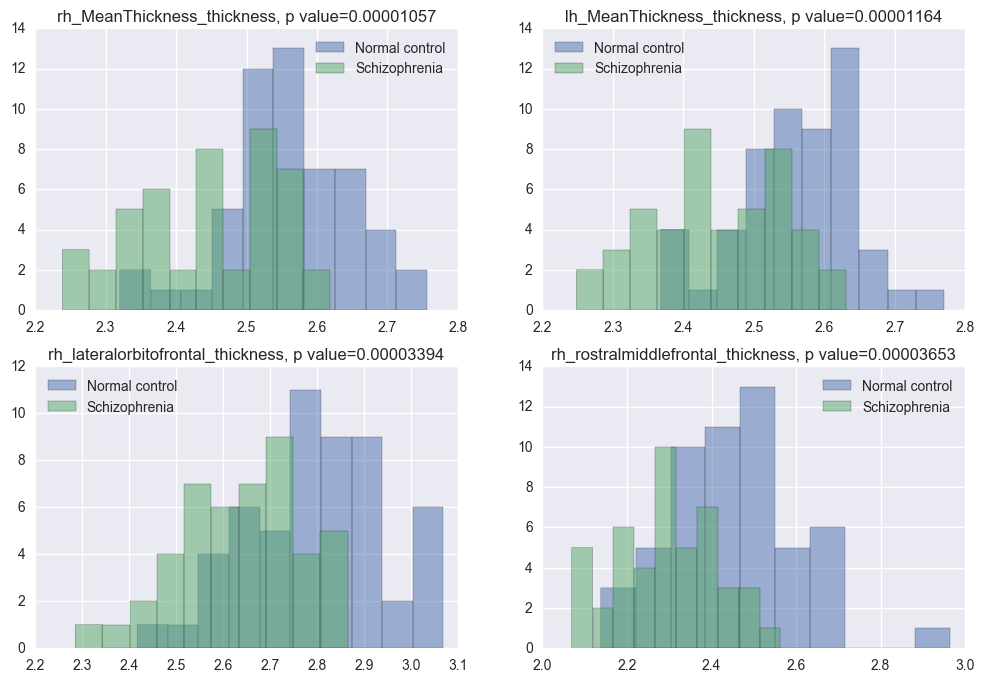

In [23]:
plot_n_hist(desik, 4)

### Destrieux

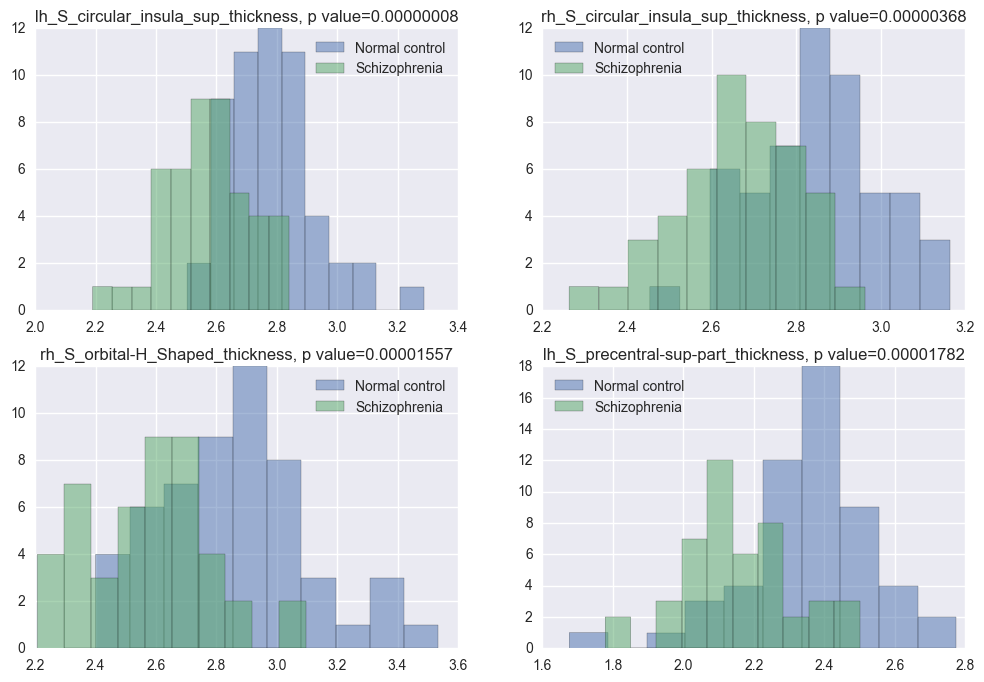

In [24]:
plot_n_hist(destr, 4)

### Yeo7

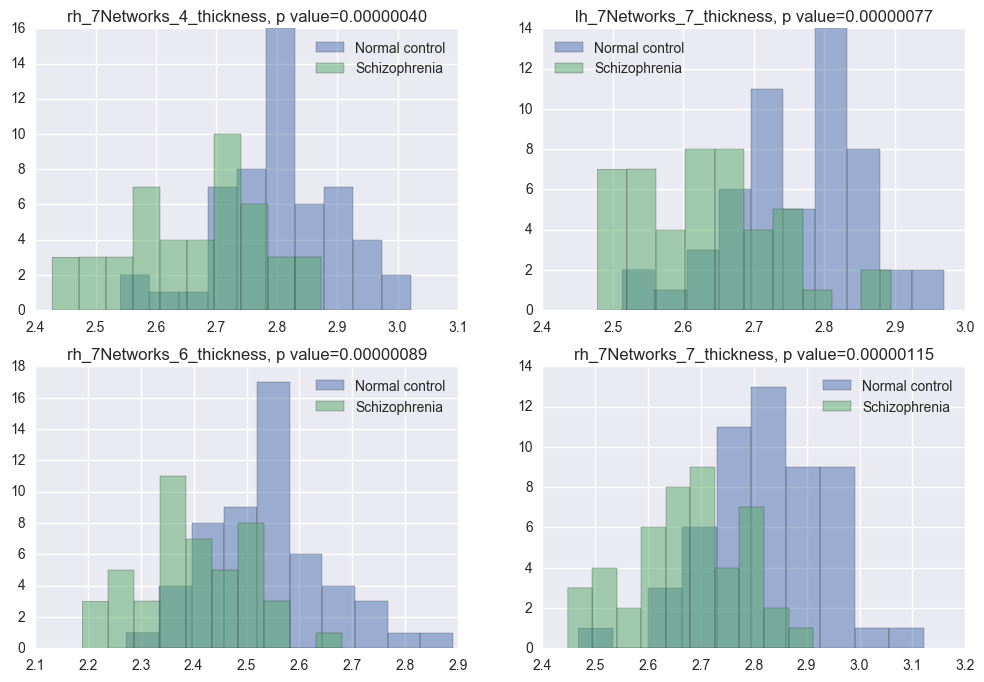

In [25]:
plot_n_hist(yeo7, 4)

### Yeo17

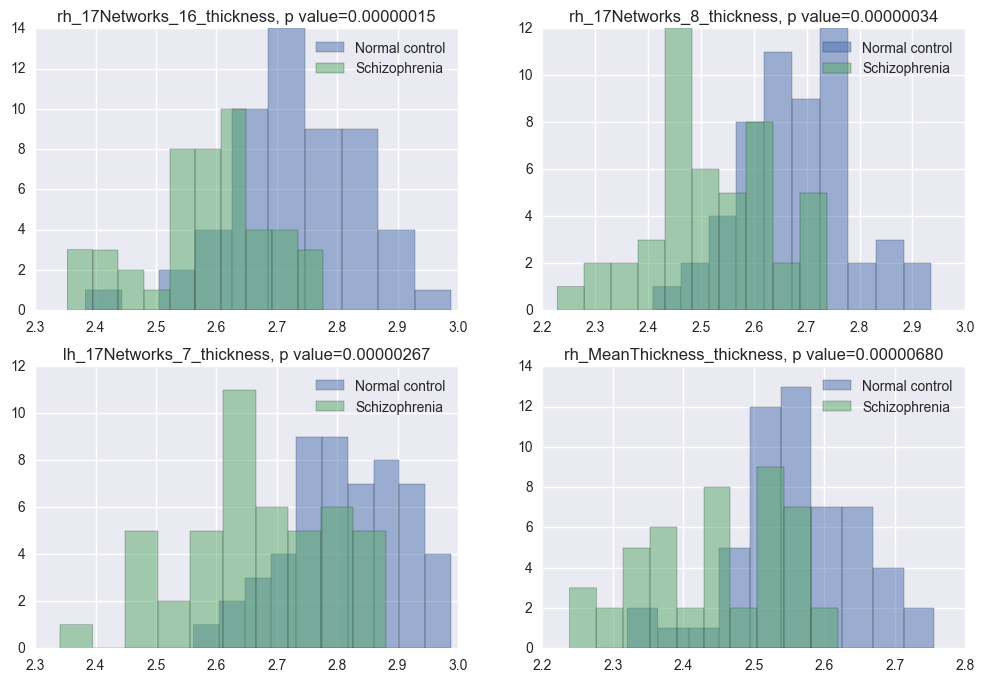

In [26]:
plot_n_hist(yeo17, 4)

### Pairplot для данных признаков

Pairplot for 3 best features in Desikan:


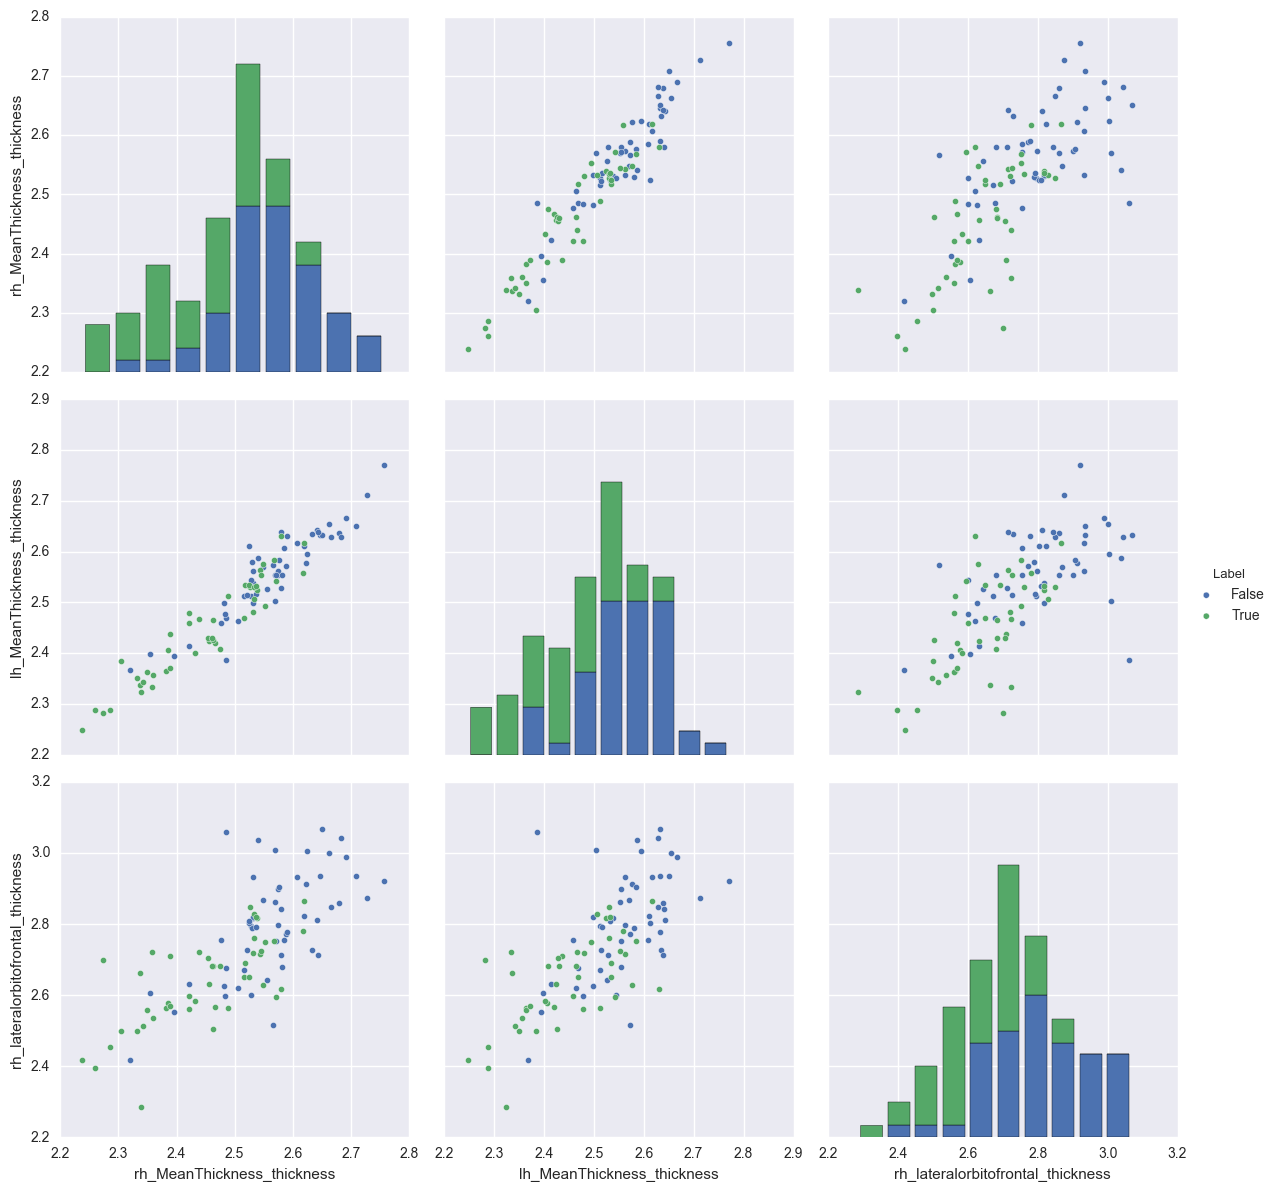

Pairplot for 3 best features in Destrieux:


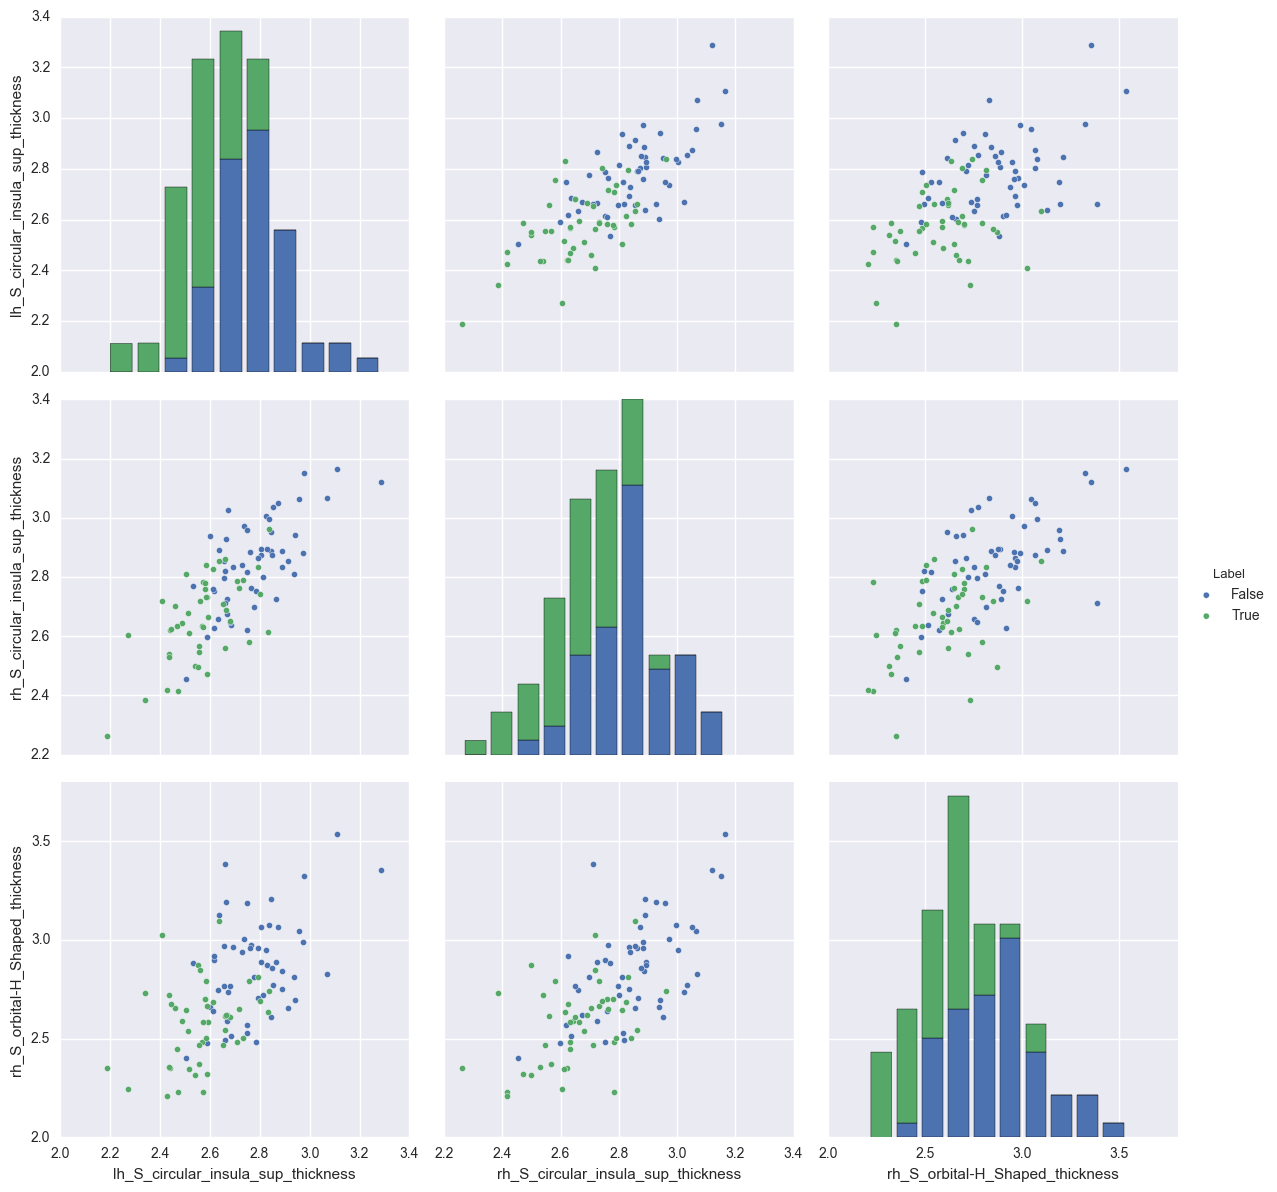

Pairplot for 3 best features in Yeo7Networks:


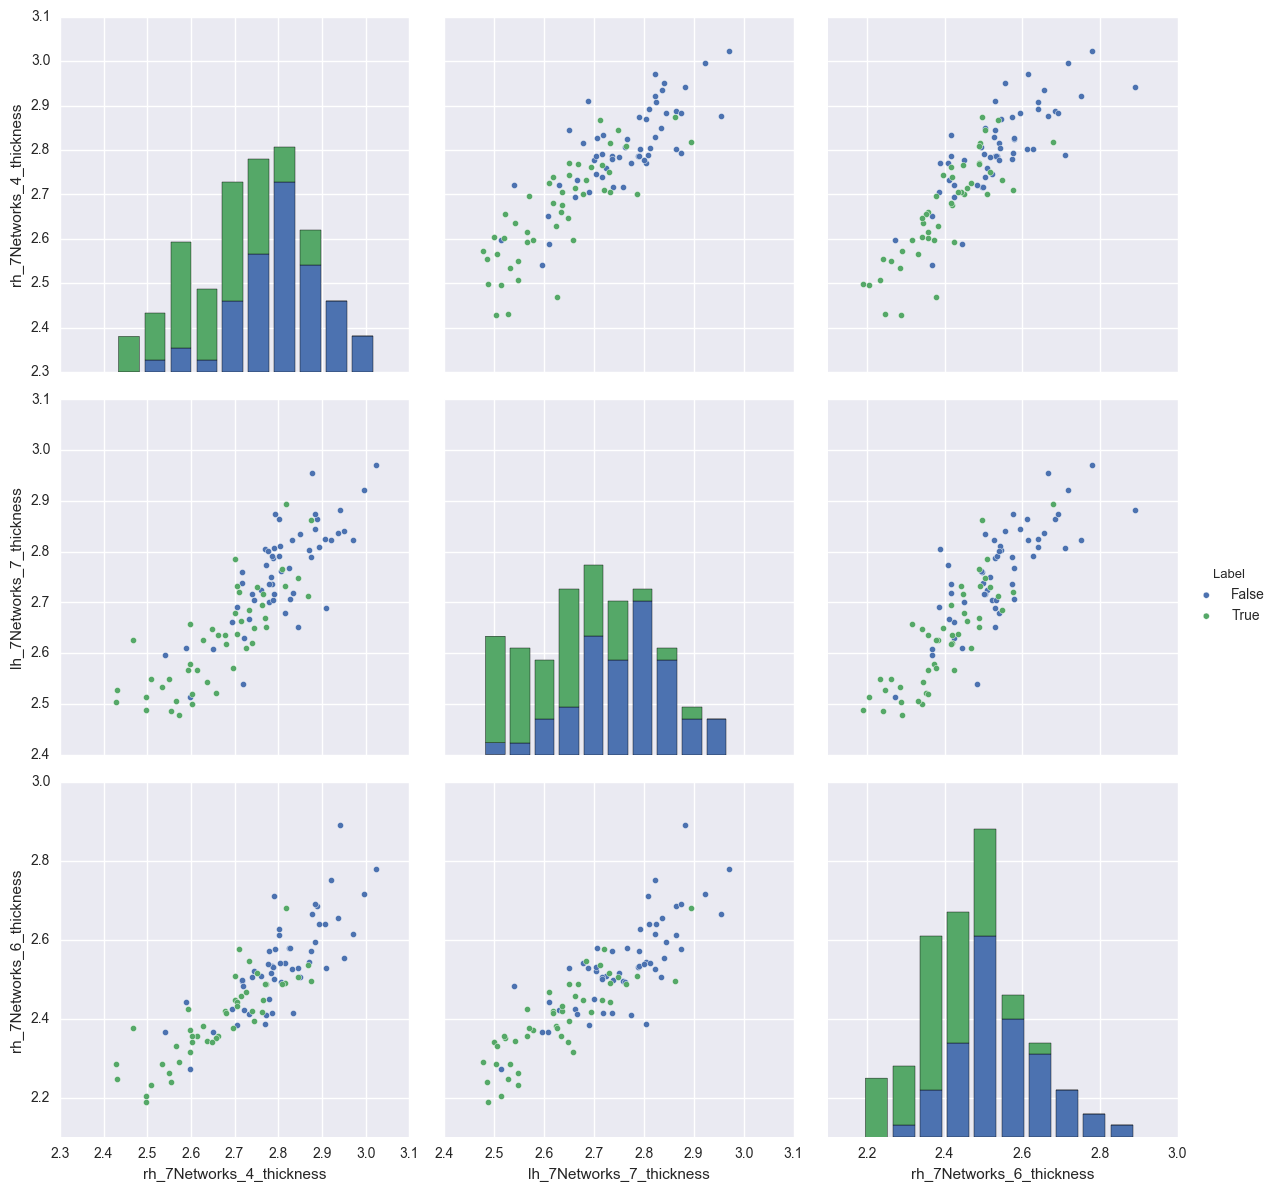

Pairplot for 3 best features in Yeo17Networks:


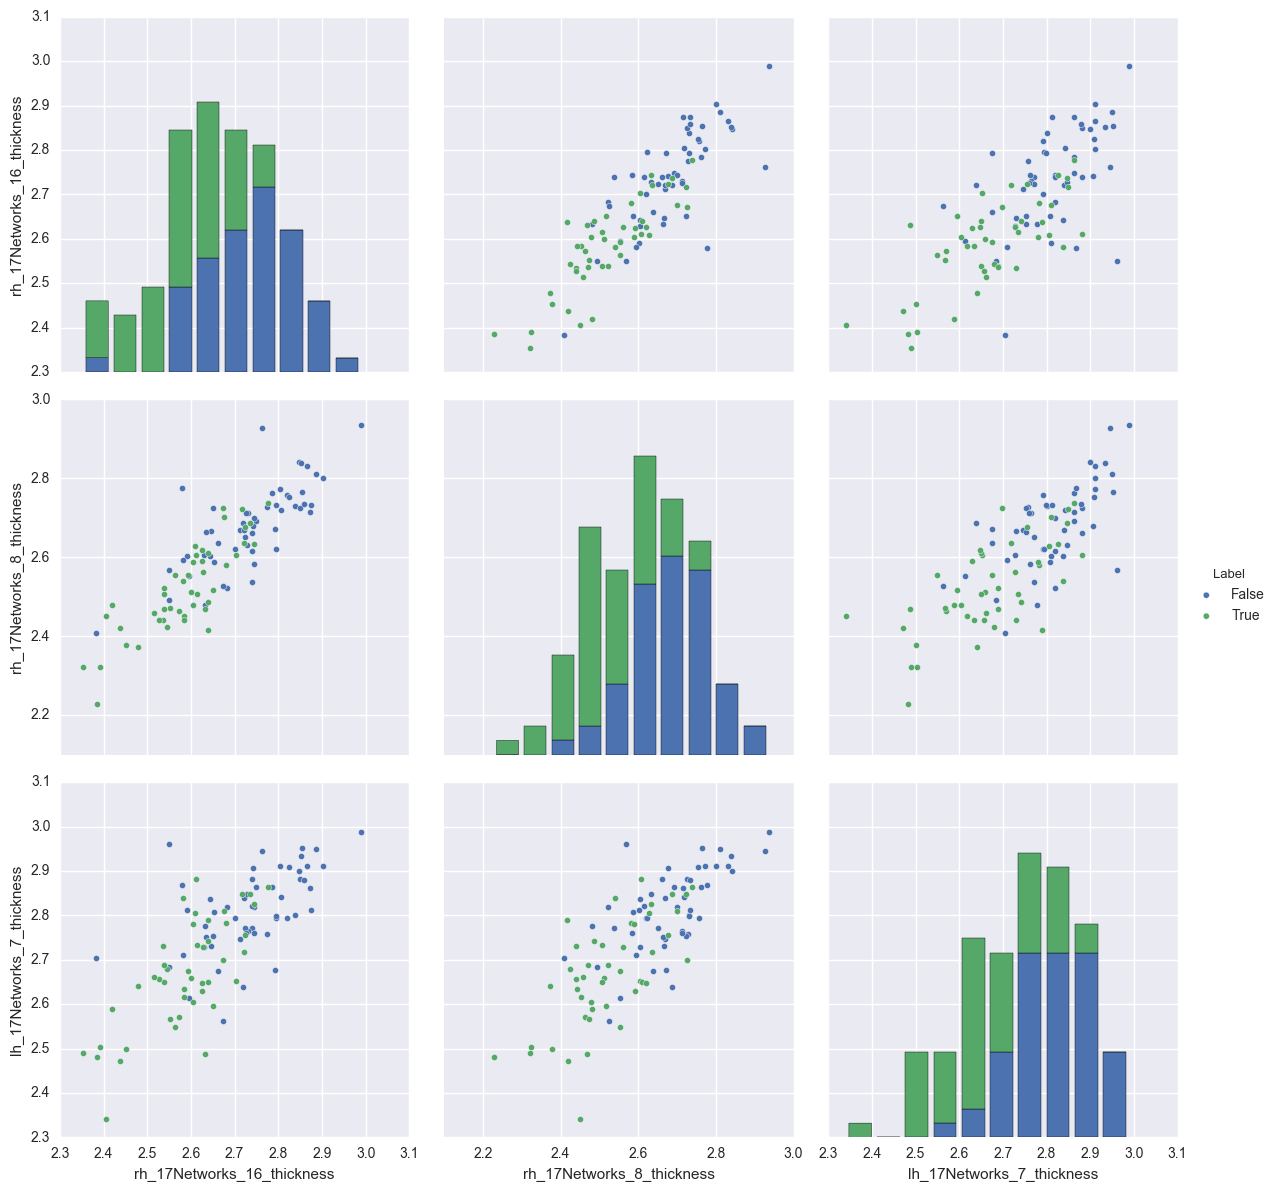

In [189]:
data = {}
features_to_plot = {}
for atlas in [desik, destr, yeo7, yeo17]:
    data[atlas] = X[atlas].copy()
    print('Pairplot for 3 best features in {}:'.format(atlas))
    features_to_plot[atlas] = stats[atlas].index[:3]
    data[atlas]['Label'] = y[atlas]
    sns.pairplot(data = data[atlas], hue = 'Label', vars = data[atlas][features_to_plot[atlas]], size = 4)
    sns.plt.show()

### Проверка модели на тестовой выборке

In [27]:
kfold_num = 5
prime_numbers = [13, 17, 41, 43, 223, 227, 229, 233, 239, 2699]
prime_numbers_big = [13, 17, 41, 43, 223, 227, 229, 233, 239, 593, 787, 1289, 2161, 2699, 3023, 3529]

def get_quality_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall_sens = recall_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    specifity = matrix[0, 0] / sum(matrix[0])
    return accuracy, recall_sens, specifity

def evaluate_model(clf, X, y, verbose = 1):
    y_preds = []
    for n in prime_numbers_big:
        skfold = StratifiedKFold(n_splits=kfold_num, shuffle=True, random_state=n)
        y_preds.append(cross_val_predict(clf, X, y, cv=skfold, n_jobs=-1))

    scores = zip(*[get_quality_metrics(y, y_pred) for y_pred in y_preds])
    scores_dict = {}
    scores_array = []
    for name, score in zip(['accuracy', 'recall', 'specifity'],  scores):
        scores_dict[name] = [np.mean(score), np.std(score)]
        scores_array.append(scores_dict[name][0])
        scores_array.append(scores_dict[name][1])
    if verbose == 1:
        for name, score in zip(['Точность', 'Чувствительность', 'Специфичность'],  scores):
            print('{:17s}: {:.3f} ± {:.3f}'.format(name, np.mean(score), np.std(score)))
    return scores_array, scores_dict

In [28]:
def calculate_quality(atlases, clf, X, y, X_train, y_train, X_test, y_test, params):
    frames = []
    for atlas in atlases:   
# Кросс валидация на трэйне
        clf1 = clone(clf) 
        scores1 = evaluate_model(clf1, X_train[atlas][params[atlas]], y_train[atlas])

# Обучение на трэйне и метрики на тесте
        clf2 = clone(clf)
        clf2.fit(X_train[atlas][params[atlas]], y_train[atlas])
        y_pred = clf2.predict(X_test[atlas][params[atlas]])
        scores2 = get_quality_metrics(y_test[atlas], y_pred)
        #for name, score in zip(['Точность', 'Чувствительность', 'Специфичность'],  scores):
        #    print('{:17s}: {:.3f}'.format(name, score))
        roc_auc = roc_auc_score(y_test[atlas], clf2.predict_proba(X_test[atlas][params[atlas]])[:,1])
        #print('{:17s}: {:.3f}'.format('ROC AUC', roc_auc))
    
#Кросс-валидация на всей выборке    
        clf3 = clone(clf)
        scores3 = evaluate_model(clf3, X[atlas][params[atlas]], y[atlas])
#Оформление датафрейма       
        err_test = np.concatenate((scores2,np.array([roc_auc])))
        err_test = np.array(['{:.3f}'.format(err_test[i]) for i in range(4)]).reshape((4,1))
        cv_train = np.concatenate((['{:.3f} ± {:.3f}'.format(scores1[0][2*i], 
                                                             scores1[0][2*i+1]) for i in range(3)],[np.nan])).reshape((4,1))
        cv_full = np.concatenate((['{:.3f} ± {:.3f}'.format(scores3[0][2*i], 
                                                             scores3[0][2*i+1]) for i in range(3)],[np.nan])).reshape((4,1))
        
        data = np.concatenate((cv_train,err_test,cv_full),axis=1)
        cols = pd.MultiIndex.from_product([[atlas],['CV train', 'Err on test', 'CV full']])
        frames.append(pd.DataFrame(data = data, index = ['Точность', 'Чувствительность','Специфичность','ROC AUC'], 
                                   columns = cols))
    return pd.concat(frames,axis=1)

#### Логистическая регрессия

In [ ]:
clf_logreg = make_pipeline(StandardScaler(), LogisticRegressionCV(Cs=30, n_jobs = -1))
df1 = calculate_quality(atlases, clf_logreg, X, y, X_train, y_train, X_test, y_test, all_params)

In [73]:
df1[[desik,destr]]

Desikan                                 Destrieux  \
                       CV train Err on test        CV full       CV train   
Точность          0.776 ± 0.033       0.636  0.744 ± 0.019  0.809 ± 0.024   
Чувствительность  0.694 ± 0.051       0.533  0.663 ± 0.039  0.742 ± 0.036   
Специфичность     0.847 ± 0.034       0.722  0.812 ± 0.029  0.866 ± 0.034   
ROC AUC                     nan       0.726            nan            nan   

                                             
                 Err on test        CV full  
Точность               0.727  0.783 ± 0.020  
Чувствительность       0.733  0.727 ± 0.040  
Специфичность          0.722  0.831 ± 0.035  
ROC AUC                0.770            nan

In [37]:
df1[[yeo7,yeo17]]

Yeo7Networks                             Yeo17Networks  \
                       CV train Err on test        CV full       CV train   
Точность          0.822 ± 0.032       0.697  0.759 ± 0.020  0.839 ± 0.029   
Чувствительность  0.782 ± 0.040       0.667  0.681 ± 0.032  0.804 ± 0.045   
Специфичность     0.856 ± 0.042       0.722  0.826 ± 0.033  0.868 ± 0.033   
ROC AUC                     nan       0.756            nan            nan   

                                             
                 Err on test        CV full  
Точность               0.727  0.755 ± 0.020  
Чувствительность       0.667  0.678 ± 0.032  
Специфичность          0.778  0.821 ± 0.023  
ROC AUC                0.722            nan

##### Более детальный атлас дает более точную классификацию при использовании логистической регрессии

#### Метод опорных векторов

In [39]:
C_range = np.logspace(-5, 5, 21)
gamma_range = np.logspace(-13, 4, 17)
param_grid = dict(gamma=gamma_range, C=C_range)
clf_svc = make_pipeline(StandardScaler(),
                        GridSearchCV(SVC(probability=True), param_grid=param_grid, scoring= "accuracy",
                                     cv=StratifiedKFold(n_splits=kfold_num, shuffle=True), n_jobs=-1))
df2 = calculate_quality(atlases, clf_svc, X, y, X_train, y_train, X_test, y_test, all_params)

In [40]:
df2[[desik,destr]]

Desikan                                 Destrieux  \
                       CV train Err on test        CV full       CV train   
Точность          0.770 ± 0.030       0.667  0.741 ± 0.021  0.820 ± 0.023   
Чувствительность  0.706 ± 0.055       0.533  0.694 ± 0.040  0.772 ± 0.043   
Специфичность     0.825 ± 0.045       0.778  0.781 ± 0.030  0.861 ± 0.031   
ROC AUC                     nan       0.719            nan            nan   

                                             
                 Err on test        CV full  
Точность               0.697  0.797 ± 0.024  
Чувствительность       0.600  0.742 ± 0.034  
Специфичность          0.778  0.844 ± 0.033  
ROC AUC                0.770            nan

In [41]:
df2[[yeo7,yeo17]]

Yeo7Networks                             Yeo17Networks  \
                       CV train Err on test        CV full       CV train   
Точность          0.800 ± 0.028       0.758  0.754 ± 0.022  0.821 ± 0.030   
Чувствительность  0.746 ± 0.039       0.667  0.688 ± 0.029  0.802 ± 0.036   
Специфичность     0.847 ± 0.042       0.833  0.811 ± 0.031  0.837 ± 0.037   
ROC AUC                     nan       0.763            nan            nan   

                                             
                 Err on test        CV full  
Точность               0.636  0.761 ± 0.026  
Чувствительность       0.533  0.692 ± 0.053  
Специфичность          0.722  0.821 ± 0.025  
ROC AUC                0.744            nan

##### И для метода опорных векторов более детальный атлас дает более точную классификацию

### Проведем анализ значимости толщины, объема и площади

#### Логистическая регрессия

In [46]:
thick_logreg = calculate_quality(atlases, clf_logreg, X, y, X_train, y_train, X_test, y_test, thickness_idx)
volume_logreg = calculate_quality(atlases, clf_logreg, X, y, X_train, y_train, X_test, y_test, volume_idx)
area_logreg = calculate_quality(atlases, clf_logreg, X, y, X_train, y_train, X_test, y_test, area_idx)

In [51]:
pd.concat([thick_logreg[[desik, destr]],volume_logreg[[desik, destr]],area_logreg[[desik, destr]]], keys = ['Thickness', 'Volume', 'Area'])

Desikan                             \
                                 CV train Err on test        CV full   
Thickness Точность          0.757 ± 0.013       0.636  0.705 ± 0.025   
          Чувствительность  0.657 ± 0.034       0.533  0.605 ± 0.026   
          Специфичность     0.844 ± 0.019       0.722  0.791 ± 0.039   
          ROC AUC                     nan       0.689            nan   
Volume    Точность          0.625 ± 0.030       0.667  0.654 ± 0.019   
          Чувствительность  0.401 ± 0.051       0.333  0.519 ± 0.029   
          Специфичность     0.818 ± 0.050       0.944  0.769 ± 0.038   
          ROC AUC                     nan       0.789            nan   
Area      Точность          0.504 ± 0.021       0.485  0.493 ± 0.031   
          Чувствительность  0.141 ± 0.092       0.400  0.158 ± 0.043   
          Специфичность     0.816 ± 0.090       0.556  0.779 ± 0.063   
          ROC AUC                     nan       0.522            nan   

                                Destrieux                             
                                 CV train Err on test        CV full  
Thickness Точность          0.814 ± 0.029       0.758  0.770 ± 0.028  
          Чувствительность  0.768 ± 0.041       0.733  0.731 ± 0.043  
          Специфичность     0.854 ± 0.039       0.778  0.803 ± 0.031  
          ROC AUC                     nan       0.767            nan  
Volume    Точность          0.638 ± 0.031       0.667  0.667 ± 0.011  
          Чувствительность  0.440 ± 0.056       0.333  0.572 ± 0.046  
          Специфичность     0.809 ± 0.053       0.944  0.749 ± 0.025  
          ROC AUC                     nan       0.807            nan  
Area      Точность          0.528 ± 0.027       0.545  0.514 ± 0.024  
          Чувствительность  0.081 ± 0.044       0.000  0.162 ± 0.069  
          Специфичность     0.913 ± 0.064       1.000  0.814 ± 0.076  
          ROC AUC                     nan       0.381            nan

In [52]:
pd.concat([thick_logreg[[yeo7, yeo17]],volume_logreg[[yeo7, yeo17]],area_logreg[[yeo7, yeo17]]], keys = ['Thickness', 'Volume', 'Area'])

Yeo7Networks                             \
                                 CV train Err on test        CV full   
Thickness Точность          0.779 ± 0.018       0.636  0.741 ± 0.019   
          Чувствительность  0.710 ± 0.032       0.533  0.645 ± 0.031   
          Специфичность     0.839 ± 0.026       0.722  0.823 ± 0.039   
          ROC AUC                     nan       0.711            nan   
Volume    Точность          0.626 ± 0.028       0.788  0.668 ± 0.019   
          Чувствительность  0.433 ± 0.046       0.733  0.575 ± 0.038   
          Специфичность     0.792 ± 0.066       0.833  0.748 ± 0.039   
          ROC AUC                     nan       0.811            nan   
Area      Точность          0.549 ± 0.046       0.606  0.619 ± 0.038   
          Чувствительность  0.383 ± 0.085       0.133  0.535 ± 0.054   
          Специфичность     0.691 ± 0.096       1.000  0.690 ± 0.050   
          ROC AUC                     nan       0.533            nan   

                            Yeo17Networks                             
                                 CV train Err on test        CV full  
Thickness Точность          0.790 ± 0.011       0.606  0.736 ± 0.014  
          Чувствительность  0.732 ± 0.025       0.600  0.639 ± 0.037  
          Специфичность     0.840 ± 0.016       0.611  0.818 ± 0.028  
          ROC AUC                     nan       0.644            nan  
Volume    Точность          0.610 ± 0.033       0.758  0.660 ± 0.022  
          Чувствительность  0.421 ± 0.048       0.600  0.507 ± 0.029  
          Специфичность     0.773 ± 0.062       0.889  0.791 ± 0.044  
          ROC AUC                     nan       0.774            nan  
Area      Точность          0.574 ± 0.054       0.576  0.579 ± 0.047  
          Чувствительность  0.458 ± 0.104       0.467  0.402 ± 0.109  
          Специфичность     0.674 ± 0.078       0.667  0.729 ± 0.059  
          ROC AUC                     nan       0.600            nan

#### Метод опорных векторов

In [47]:
thick_svc = calculate_quality(atlases, clf_svc, X, y, X_train, y_train, X_test, y_test, thickness_idx)
volume_svc = calculate_quality(atlases, clf_svc, X, y, X_train, y_train, X_test, y_test, volume_idx)
area_svc = calculate_quality(atlases, clf_svc, X, y, X_train, y_train, X_test, y_test, area_idx)

In [53]:
pd.concat([thick_svc[[desik, destr]],volume_svc[[desik, destr]],area_svc[[desik, destr]]], keys = ['Thickness', 'Volume', 'Area'])

Desikan                             \
                                 CV train Err on test        CV full   
Thickness Точность          0.757 ± 0.013       0.606  0.725 ± 0.015   
          Чувствительность  0.681 ± 0.039       0.600  0.605 ± 0.025   
          Специфичность     0.823 ± 0.022       0.611  0.828 ± 0.032   
          ROC AUC                     nan       0.648            nan   
Volume    Точность          0.618 ± 0.034       0.697  0.641 ± 0.024   
          Чувствительность  0.433 ± 0.053       0.400  0.467 ± 0.058   
          Специфичность     0.776 ± 0.035       0.944  0.788 ± 0.042   
          ROC AUC                     nan       0.693            nan   
Area      Точность          0.495 ± 0.038       0.545  0.513 ± 0.023   
          Чувствительность  0.224 ± 0.090       0.000  0.228 ± 0.075   
          Специфичность     0.729 ± 0.086       1.000  0.756 ± 0.067   
          ROC AUC                     nan       0.500            nan   

                                Destrieux                             
                                 CV train Err on test        CV full  
Thickness Точность          0.810 ± 0.026       0.758  0.800 ± 0.027  
          Чувствительность  0.766 ± 0.052       0.733  0.788 ± 0.039  
          Специфичность     0.847 ± 0.045       0.778  0.810 ± 0.033  
          ROC AUC                     nan       0.767            nan  
Volume    Точность          0.644 ± 0.030       0.697  0.654 ± 0.020  
          Чувствительность  0.522 ± 0.074       0.467  0.549 ± 0.026  
          Специфичность     0.748 ± 0.060       0.889  0.743 ± 0.039  
          ROC AUC                     nan       0.670            nan  
Area      Точность          0.498 ± 0.034       0.485  0.517 ± 0.029  
          Чувствительность  0.236 ± 0.067       0.200  0.283 ± 0.085  
          Специфичность     0.724 ± 0.081       0.722  0.716 ± 0.051  
          ROC AUC                     nan       0.519            nan

In [54]:
pd.concat([thick_svc[[yeo7, yeo17]],volume_svc[[yeo7, yeo17]],area_svc[[yeo7, yeo17]]], keys = ['Thickness', 'Volume', 'Area'])

Yeo7Networks                             \
                                 CV train Err on test        CV full   
Thickness Точность          0.765 ± 0.028       0.636  0.736 ± 0.018   
          Чувствительность  0.716 ± 0.046       0.600  0.640 ± 0.039   
          Специфичность     0.807 ± 0.030       0.667  0.818 ± 0.033   
          ROC AUC                     nan       0.693            nan   
Volume    Точность          0.590 ± 0.031       0.727  0.652 ± 0.021   
          Чувствительность  0.429 ± 0.051       0.400  0.519 ± 0.039   
          Специфичность     0.729 ± 0.065       1.000  0.765 ± 0.052   
          ROC AUC                     nan       0.785            nan   
Area      Точность          0.527 ± 0.041       0.697  0.619 ± 0.031   
          Чувствительность  0.393 ± 0.076       0.533  0.557 ± 0.058   
          Специфичность     0.642 ± 0.071       0.833  0.671 ± 0.039   
          ROC AUC                     nan       0.659            nan   

                            Yeo17Networks                             
                                 CV train Err on test        CV full  
Thickness Точность          0.807 ± 0.036       0.545  0.734 ± 0.020  
          Чувствительность  0.770 ± 0.064       0.533  0.659 ± 0.032  
          Специфичность     0.839 ± 0.033       0.556  0.797 ± 0.032  
          ROC AUC                     nan       0.630            nan  
Volume    Точность          0.600 ± 0.035       0.758  0.651 ± 0.024  
          Чувствительность  0.433 ± 0.060       0.600  0.484 ± 0.024  
          Специфичность     0.743 ± 0.071       0.889  0.793 ± 0.051  
          ROC AUC                     nan       0.767            nan  
Area      Точность          0.560 ± 0.037       0.545  0.555 ± 0.032  
          Чувствительность  0.409 ± 0.080       0.333  0.459 ± 0.050  
          Специфичность     0.689 ± 0.053       0.722  0.637 ± 0.042  
          ROC AUC                     nan       0.544            nan

### Анализ по двум признакам: средние толщины зон по полушариям

In [58]:
print('\t \t \t \t Normal \t \t Schizophrenia')
print('{:30s}: {:.3f} ± {:.3f} \t \t {:.3f} ± {:.3f}'.format('lh_MeanThickness_thickness', X[desik]['lh_MeanThickness_thickness'][y[atlas]==0].values.mean(), X[desik]['lh_MeanThickness_thickness'][y[atlas]==0].values.std(), X[desik]['lh_MeanThickness_thickness'][y[atlas]==1].values.mean(), X[desik]['lh_MeanThickness_thickness'][y[atlas]==1].values.std()))
print('{:30s}: {:.3f} ± {:.3f} \t \t {:.3f} ± {:.3f}\n'.format('rh_MeanThickness_thickness', X[desik]['rh_MeanThickness_thickness'][y[atlas]==0].values.mean(), X[desik]['rh_MeanThickness_thickness'][y[atlas]==0].values.std(), X[desik]['rh_MeanThickness_thickness'][y[atlas]==1].values.mean(), X[desik]['rh_MeanThickness_thickness'][y[atlas]==1].values.std()))
for atlas in [desik, destr]:
    print('Average thicknesses in {:10s}:\n'.format(atlas))
    print('\t \t \t \t Normal \t \t Schizophrenia')
    print('{:30s}: {:.3f} ± {:.3f} \t \t {:.3f} ± {:.3f}'.format('For prefrontal',X[atlas][frontal_th_idx[atlas]][y[atlas]==0].values.mean(), X[atlas][frontal_th_idx[atlas]][y[atlas]==0].values.std(),X[atlas][frontal_th_idx[atlas]][y[atlas]==1].values.mean(), X[atlas][frontal_th_idx[atlas]][y[atlas]==1].values.std()))
    print('{:30s}: {:.3f} ± {:.3f} \t \t {:.3f} ± {:.3f}\n'.format('For non-prefrontal',X[atlas][nonfrontal_th_idx[atlas]][y[atlas]==0].values.mean(), X[atlas][nonfrontal_th_idx[atlas]][y[atlas]==0].values.std(),X[atlas][nonfrontal_th_idx[atlas]][y[atlas]==1].values.mean(), X[atlas][nonfrontal_th_idx[atlas]][y[atlas]==1].values.std()))

	 	 	 	 Normal 	 	 Schizophrenia
lh_MeanThickness_thickness    : 2.561 ± 0.082 	 	 2.447 ± 0.095
rh_MeanThickness_thickness    : 2.567 ± 0.086 	 	 2.449 ± 0.099

Average thicknesses in Desikan   :

	 	 	 	 Normal 	 	 Schizophrenia
For prefrontal                : 2.700 ± 0.244 	 	 2.556 ± 0.222
For non-prefrontal            : 2.645 ± 0.532 	 	 2.548 ± 0.527

Average thicknesses in Destrieux :

	 	 	 	 Normal 	 	 Schizophrenia
For prefrontal                : 2.614 ± 0.339 	 	 2.471 ± 0.329
For non-prefrontal            : 2.599 ± 0.487 	 	 2.488 ± 0.482



#### Логистической регрессией

In [42]:
mean_cols = {desik : ['lh_MeanThickness_thickness', 'rh_MeanThickness_thickness']}
df3 = calculate_quality([desik], clf_logreg, X, y, X_train, y_train, X_test, y_test, mean_cols)

In [43]:
df3

Desikan                           
                       CV train Err on test        CV full
Точность          0.774 ± 0.016       0.606  0.732 ± 0.011
Чувствительность  0.649 ± 0.030       0.533  0.591 ± 0.008
Специфичность     0.882 ± 0.016       0.667  0.852 ± 0.023
ROC AUC                     nan       0.693            nan

#### Методом опорных векторов

In [44]:
df4 = calculate_quality([desik], clf_svc, X, y, X_train, y_train, X_test, y_test, mean_cols)

In [45]:
df4

Desikan                           
                       CV train Err on test        CV full
Точность          0.757 ± 0.031       0.606  0.727 ± 0.019
Чувствительность  0.655 ± 0.045       0.533  0.582 ± 0.025
Специфичность     0.844 ± 0.042       0.667  0.851 ± 0.022
ROC AUC                     nan       0.678            nan

## Проверим гипотезу о том, что наибольший вклад вносят толщины зон из префронтальной коры

In [48]:
prefrontal_logreg = calculate_quality([desik, destr], clf_logreg, X, y, X_train, y_train, X_test, y_test, frontal_th_idx)
nonfrontal_logreg = calculate_quality([desik, destr], clf_logreg, X, y, X_train, y_train, X_test, y_test, nonfrontal_th_idx)

prefrontal_svc = calculate_quality([desik, destr], clf_svc, X, y, X_train, y_train, X_test, y_test, frontal_th_idx)
nonfrontal_svc = calculate_quality([desik, destr], clf_svc, X, y, X_train, y_train, X_test, y_test, nonfrontal_th_idx)

#### Логистическая регрессия

In [57]:
pd.concat([prefrontal_logreg[[desik, destr]],nonfrontal_logreg[[desik, destr]]], keys = ['Prefrontal', 'Other'])

Desikan                             \
                                  CV train Err on test        CV full   
Prefrontal Точность          0.809 ± 0.014       0.697  0.736 ± 0.031   
           Чувствительность  0.730 ± 0.019       0.600  0.666 ± 0.041   
           Специфичность     0.877 ± 0.020       0.778  0.796 ± 0.039   
           ROC AUC                     nan       0.711            nan   
Other      Точность          0.771 ± 0.028       0.576  0.688 ± 0.019   
           Чувствительность  0.685 ± 0.046       0.533  0.582 ± 0.026   
           Специфичность     0.844 ± 0.038       0.611  0.778 ± 0.029   
           ROC AUC                     nan       0.637            nan   

                                 Destrieux                             
                                  CV train Err on test        CV full  
Prefrontal Точность          0.785 ± 0.025       0.697  0.724 ± 0.022  
           Чувствительность  0.706 ± 0.036       0.600  0.659 ± 0.027  
           Специфичность     0.854 ± 0.029       0.778  0.780 ± 0.040  
           ROC AUC                     nan       0.715            nan  
Other      Точность          0.800 ± 0.022       0.636  0.761 ± 0.031  
           Чувствительность  0.728 ± 0.025       0.667  0.705 ± 0.054  
           Специфичность     0.863 ± 0.042       0.611  0.809 ± 0.030  
           ROC AUC                     nan       0.774            nan

#### SVC

In [56]:
pd.concat([prefrontal_svc[[desik, destr]],nonfrontal_svc[[desik, destr]]], keys = ['Prefrontal', 'Other'])

Desikan                             \
                                  CV train Err on test        CV full   
Prefrontal Точность          0.805 ± 0.021       0.697  0.748 ± 0.020   
           Чувствительность  0.742 ± 0.030       0.600  0.655 ± 0.022   
           Специфичность     0.859 ± 0.029       0.778  0.826 ± 0.035   
           ROC AUC                     nan       0.730            nan   
Other      Точность          0.747 ± 0.021       0.515  0.690 ± 0.030   
           Чувствительность  0.651 ± 0.026       0.600  0.567 ± 0.037   
           Специфичность     0.830 ± 0.037       0.444  0.795 ± 0.041   
           ROC AUC                     nan       0.552            nan   

                                 Destrieux                             
                                  CV train Err on test        CV full  
Prefrontal Точность          0.776 ± 0.022       0.697  0.728 ± 0.025  
           Чувствительность  0.702 ± 0.035       0.600  0.633 ± 0.032  
           Специфичность     0.840 ± 0.029       0.778  0.809 ± 0.044  
           ROC AUC                     nan       0.704            nan  
Other      Точность          0.829 ± 0.022       0.636  0.759 ± 0.038  
           Чувствительность  0.768 ± 0.044       0.667  0.696 ± 0.061  
           Специфичность     0.882 ± 0.032       0.611  0.812 ± 0.035  
           ROC AUC                     nan       0.767            nan

Для менее подробного атласа Desikan, действительно, наблюдается уменьшение качетсва классификации при использовании только тех зон, которые не принадлежащих префронтальной коре, по сравнению с теми, которые принадлежат. 

Чего нельзя сказать про более подробный атлас Destrieux. На кросс-валидации по всей выборке качество анализа по Non-Prerontal превосходит качество анализа по Prefrontal признакам. Хотя точность и специфичность на тестовой выборке при анализе по Non-Prefrontal зонам получились ниже, чем по Prefrontal, но чувствительность и ROC AUC выше.  

## Анализ значимых компонент при построении классификатора методом логистической регрессии для атласов Destrieux и Desikan

In [32]:
def get_feature_logreg(X, y, random_state):
    cv = StratifiedKFold(n_splits=kfold_num, shuffle=True, random_state = random_state)
    clf = make_pipeline(StandardScaler(), LogisticRegressionCV(Cs = 30, penalty='l1', solver = 'liblinear', cv = cv, n_jobs = -1))
    clf.fit(X, y)
    return clf.steps[1][1].coef_[0]    

In [38]:
def get_sorted_feature(X, y, random_state):
    coefs = np.zeros((X.columns.size+1, len(random_state)+2))
    for idx, random_state_i in enumerate(random_state):
        coefs[:-1,idx] = get_feature_logreg(X, y, random_state_i)
    
    coefs = np.abs(coefs)
    for i in range(len(random_state)):
        coefs[-1, i] = sum(coefs[:-1,i])
        coefs[:-1, i] = coefs[:-1, i]/coefs[-1, i]  
    
    coefs[:-1,-2] = coefs[:-1,:-2].mean(axis = 1)
    coefs[:-1,-1] = coefs[:-1,:-2].std(axis = 1)
    
    df_clf_coef = pd.DataFrame(data = coefs[:-1,-2:], columns = ['mean_importance', 'std'], index = X.columns) 
    df_coef_sorted = df_clf_coef.sort_values(['mean_importance'], ascending=[False])
    df_coef_sorted["key"] = df_coef_sorted.index
    df_coef_sorted.index = range(X.columns.size)
    
    return df_coef_sorted

In [39]:
def merge_features_to_stats(df_coef_sorted_, stats, frontal_th_idx, p_value_bound):
    df_coef_sorted = df_coef_sorted_.copy()
    df_coef_sorted['p value'] = [stats['p value'][i] for i in df_coef_sorted.key]
    df_coef_sorted[r'p value < {:.4f}'.format(p_value_bound)] = [df_coef_sorted['p value'][i] < p_value_bound for i in df_coef_sorted.index]
    df_coef_sorted['Prefrontal'] = [idx in frontal_th_idx for idx in df_coef_sorted.key]
    return df_coef_sorted

### Проведем анализ по всем признакам

In [35]:
df_coef_merged = {}
df_coef_sorted = {}

for atlas in atlases:
    df_coef_sorted[atlas] = get_sorted_feature(X[atlas], y[atlas], prime_numbers)
    if atlas in [desik, destr]:
        df_coef_merged[atlas] = merge_features_to_stats(df_coef_sorted[atlas], stats[atlas], frontal_th_idx[atlas], p_value_bound = 1e-2)
    
df_coef_first_20 = {}
for atlas in atlases:
    if atlas in [desik, destr]:
        df_coef_first_20[atlas] = df_coef_merged[atlas][['key','mean_importance','std','p value', 
                                                         'p value < 0.0100','Prefrontal']][:20]
    else:
        df_coef_first_20[atlas] = df_coef_sorted[atlas][['key','mean_importance','std']][:20]

In [36]:
print('Первые 20 наиболее значимых признаков для логистической регрессии для атласа Desikan\nmean importnace - средний вес признака в модели, нормированный на сумму весов по всем признакам данной модели')
df_coef_first_20[desik]

Первые 20 наиболее значимых признаков для логистической регрессии для атласа Desikan
mean importnace - средний вес признака в модели, нормированный на сумму весов по всем признакам данной модели


,key,mean importance,std,p value,p value < 0.0100,Prefrontal
0,Optic-Chiasm,0.096351,0.029889,0.013469,False,False
1,Left-Inf-Lat-Vent,0.072011,0.029495,0.020264,False,False
2,rh_parstriangularis_thickness,0.062489,0.029109,0.000382,True,True
3,lh_rostralanteriorcingulate_volume,0.055324,0.019408,0.065177,False,False
4,lh_superiorfrontal_thickness,0.053607,0.019774,0.000047,True,True
5,rh_lateralorbitofrontal_thickness,0.052562,0.029946,0.000034,True,True
6,rh_transversetemporal_area,0.049750,0.014123,1.000000,False,False
7,3rd-Ventricle,0.048390,0.012594,0.072263,False,False
8,rh_postcentral_area,0.042651,0.016380,1.000000,False,False
9,Right-Putamen,0.038793,0.015714,1.000000,False,False


In [37]:
print('Первые 20 наиболее значимых признаков для логистической регрессии для атласа Destrieux')
df_coef_first_20[destr]

Первые 20 наиболее значимых признаков для логистической регрессии для атласа Destrieux


,key,mean importance,std,p value,p value < 0.0100,Prefrontal
0,lh_S_circular_insula_sup_thickness,0.067562,0.060827,8.063066e-08,True,False
1,lh_Lat_Fis-ant-Horizont_thickness,0.048350,0.036761,5.410641e-02,False,True
2,Left-Inf-Lat-Vent,0.041734,0.039170,3.834406e-02,False,False
3,Optic-Chiasm,0.038996,0.027574,2.548545e-02,False,False
4,lh_S_circular_insula_sup_volume,0.034521,0.027413,7.394427e-03,True,False
5,rh_S_orbital_lateral_thickness,0.027126,0.023049,1.306998e-02,False,True
6,rh_S_orbital-H_Shaped_thickness,0.023636,0.016160,1.557337e-05,True,True
7,lh_S_interm_prim-Jensen_thickness,0.020943,0.008174,1.902203e-01,False,False
8,lh_G_oc-temp_med-Parahip_thickness,0.020870,0.007629,1.000000e+00,False,False
9,lh_G_pariet_inf-Angular_area,0.020836,0.011215,1.000000e+00,False,False


In [38]:
print('Пересечения значимых компонент для метода логистической регрессии и параметров, по которым выборки значимо различаются для \nDesikan')
df_coef_first_20[desik][df_coef_first_20[desik]['p value < 0.0100']]

Пересечения значимых компонент для метода логистической регрессии и параметров, по которым выборки значимо различаются для 
Desikan


,key,mean importance,std,p value,p value < 0.0100,Prefrontal
2,rh_parstriangularis_thickness,0.062489,0.029109,0.000382,True,True
4,lh_superiorfrontal_thickness,0.053607,0.019774,0.000047,True,True
5,rh_lateralorbitofrontal_thickness,0.052562,0.029946,0.000034,True,True
14,lh_precuneus_thickness,0.023159,0.015144,0.000241,True,False
15,lh_medialorbitofrontal_thickness,0.020095,0.011039,0.001537,True,True
16,lh_superiortemporal_thickness,0.020086,0.007887,0.000580,True,False


In [39]:
print('Пересечения значимых компонент для метода логистической регрессии и параметров, по которым выборки значимо различаются для \nDestrieux')
df_coef_first_20[destr][df_coef_first_20[destr]['p value < 0.0100']]

Пересечения значимых компонент для метода логистической регрессии и параметров, по которым выборки значимо различаются для 
Destrieux


,key,mean importance,std,p value,p value < 0.0100,Prefrontal
0,lh_S_circular_insula_sup_thickness,0.067562,0.060827,8.063066e-08,True,False
4,lh_S_circular_insula_sup_volume,0.034521,0.027413,7.394427e-03,True,False
6,rh_S_orbital-H_Shaped_thickness,0.023636,0.016160,1.557337e-05,True,True
14,rh_S_circular_insula_inf_thickness,0.014828,0.013965,3.643874e-04,True,False
15,lh_S_precentral-sup-part_thickness,0.013773,0.007277,1.781638e-05,True,False
19,rh_G_and_S_transv_frontopol_thickness,0.011733,0.006220,7.976223e-03,True,True


### Pairplots для найденных признаков

Pairplot for 3 best features in Desikan:


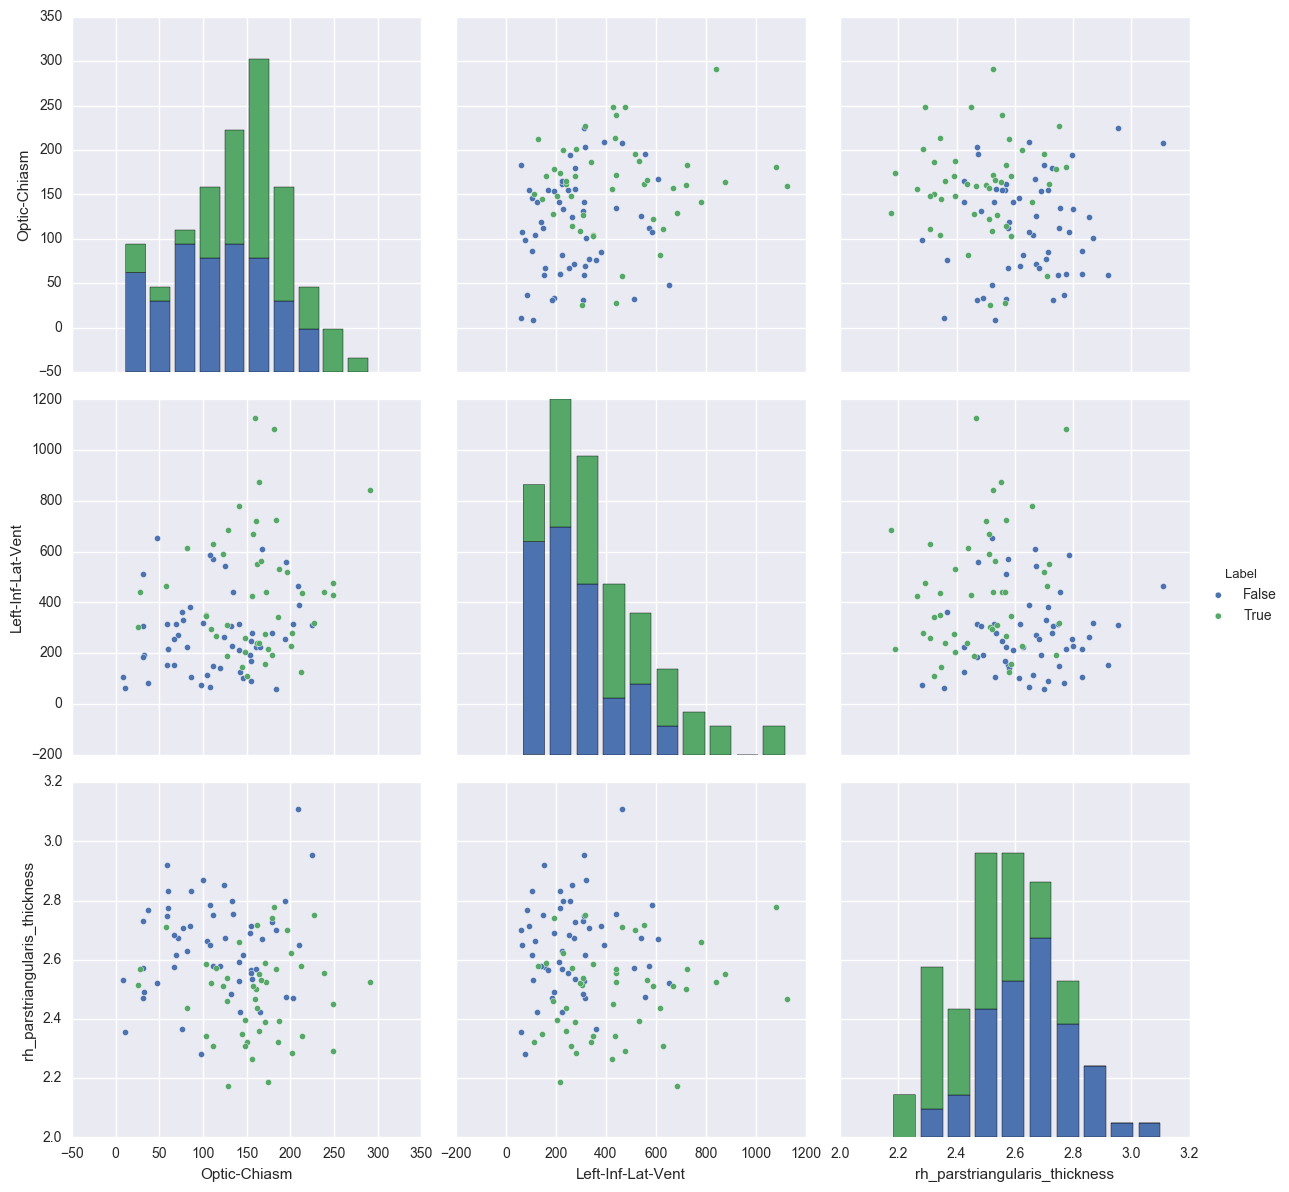

Pairplot for 3 best features in Destrieux:


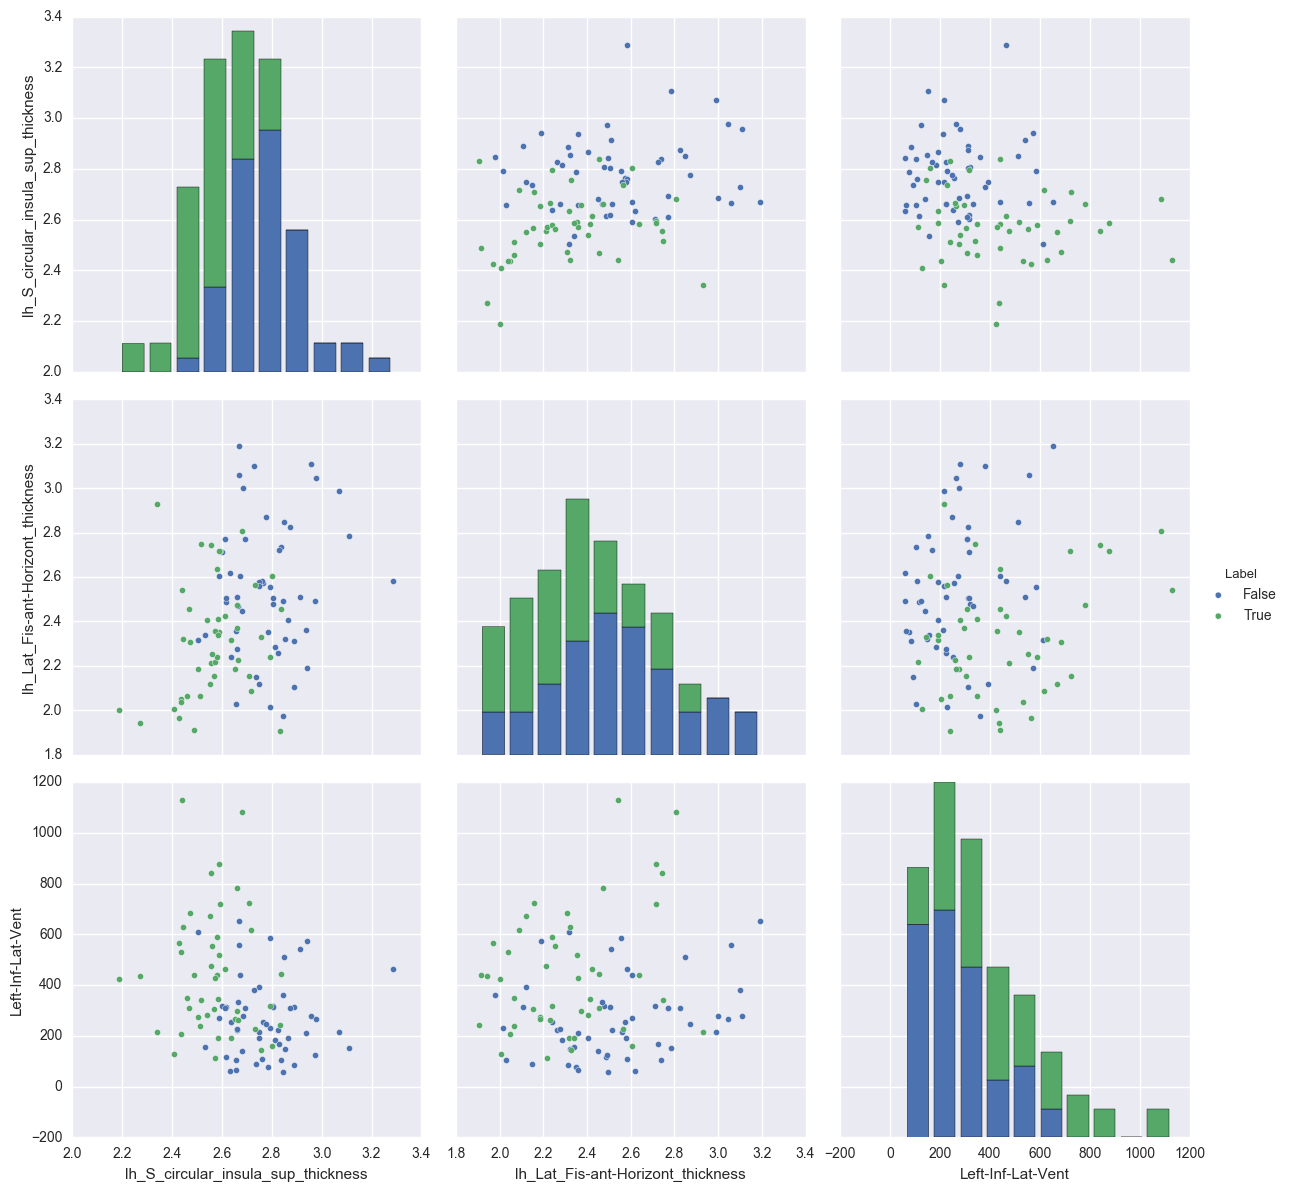

In [44]:
data = {}
features_to_plot = {}
for atlas in [desik, destr]:
    data[atlas] = X[atlas].copy()
    print('Pairplot for 3 best features in {}:'.format(atlas))
    features_to_plot[atlas] = df_coef_first_20[atlas].key.values[:3]
    data[atlas]['Label'] = y[atlas]
    sns.pairplot(data = data[atlas], hue = 'Label', vars = data[atlas][features_to_plot[atlas]], size = 4)
    sns.plt.show()

### Проведем анализ значимых компонент только по толщинам зон

In [40]:
df_coef_th_merged = {}
df_coef_th_sorted = {}

for atlas in atlases:
    #X_scaled_pd[atlas] = pd.DataFrame(data = X_scaled[atlas], columns = X[atlas].columns)
    df_coef_th_sorted[atlas] = get_sorted_feature(X[atlas][thickness_idx[atlas]], y[atlas], prime_numbers)
    if atlas in [desik, destr]:
        df_coef_th_merged[atlas] = merge_features_to_stats(df_coef_th_sorted[atlas], stats[atlas], frontal_th_idx[atlas], p_value_bound = 1e-2)

In [41]:
df_coef_th_first_20 = {}
for atlas in atlases:
    if atlas in [desik, destr]:
        df_coef_th_first_20[atlas] = df_coef_th_merged[atlas][['key','mean_importance','std','p value', 
                                                         'p value < 0.0100','Prefrontal']].query('mean_importance>0.01')[:20]
    else:
        df_coef_th_first_20[atlas] = df_coef_th_sorted[atlas][['key','mean_importance','std']].query('mean_importance>0.01')[:20]

In [44]:
print('Первые 9 наиболее значимых толщин зон для логистической регрессии для атласа Desikan (mean_importance > 0.01)')
df_coef_th_first_20[desik]

Первые 9 наиболее значимых толщин зон для логистической регрессии для атласа Desikan (mean_importance > 0.01)


,key,mean_importance,std,p value,p value < 0.0100,Prefrontal
0,lh_MeanThickness_thickness,0.269740,0.259920,0.000012,True,False
1,rh_lateralorbitofrontal_thickness,0.257819,0.051376,0.000034,True,True
2,lh_superiorfrontal_thickness,0.131870,0.058721,0.000047,True,True
3,rh_rostralmiddlefrontal_thickness,0.131342,0.045331,0.000037,True,True
4,lh_precuneus_thickness,0.050436,0.050683,0.000241,True,False
5,lh_superiortemporal_thickness,0.044388,0.045108,0.000580,True,False
6,rh_medialorbitofrontal_thickness,0.022932,0.024270,0.000933,True,True
7,lh_rostralanteriorcingulate_thickness,0.021467,0.027049,0.076043,False,False
8,rh_parstriangularis_thickness,0.013243,0.017263,0.000382,True,True
9,lh_medialorbitofrontal_thickness,0.011579,0.013758,0.001537,True,True


In [45]:
print('Первые 20 наиболее значимых толщин зон для логистической регрессии для атласа Destrieux (mean_iportance > 0.01)')
df_coef_th_first_20[destr]

Первые 20 наиболее значимых толщин зон для логистической регрессии для атласа Destrieux (mean_iportance > 0.01)


,key,mean_importance,std,p value,p value < 0.0100,Prefrontal
0,lh_Lat_Fis-ant-Horizont_thickness,0.054121,0.027689,5.410641e-02,False,True
1,lh_S_circular_insula_sup_thickness,0.049008,0.020212,8.063066e-08,True,False
2,lh_S_interm_prim-Jensen_thickness,0.036104,0.016653,1.902203e-01,False,False
3,rh_S_orbital-H_Shaped_thickness,0.034145,0.020287,1.557337e-05,True,True
4,rh_S_circular_insula_inf_thickness,0.030701,0.012857,3.643874e-04,True,False
5,lh_S_precentral-sup-part_thickness,0.028856,0.011222,1.781638e-05,True,False
6,rh_G_pariet_inf-Supramar_thickness,0.028524,0.010072,1.000000e+00,False,False
7,rh_G_temp_sup-G_T_transv_thickness,0.026690,0.007905,1.000000e+00,False,False
8,lh_G_precentral_thickness,0.025897,0.014780,1.000000e+00,False,False
9,lh_S_parieto_occipital_thickness,0.021189,0.008494,4.224362e-02,False,False


In [46]:
print('Пересечения значимых компонент для метода логистической регрессии по толщинам зон и параметров, по которым выборки значимо различаются для Desikan')
df_coef_th_first_20[desik][df_coef_th_first_20[desik]['p value < 0.0100']]

Пересечения значимых компонент для метода логистической регрессии по толщинам зон и параметров, по которым выборки значимо различаются для Desikan


,key,mean_importance,std,p value,p value < 0.0100,Prefrontal
0,lh_MeanThickness_thickness,0.269740,0.259920,0.000012,True,False
1,rh_lateralorbitofrontal_thickness,0.257819,0.051376,0.000034,True,True
2,lh_superiorfrontal_thickness,0.131870,0.058721,0.000047,True,True
3,rh_rostralmiddlefrontal_thickness,0.131342,0.045331,0.000037,True,True
4,lh_precuneus_thickness,0.050436,0.050683,0.000241,True,False
5,lh_superiortemporal_thickness,0.044388,0.045108,0.000580,True,False
6,rh_medialorbitofrontal_thickness,0.022932,0.024270,0.000933,True,True
8,rh_parstriangularis_thickness,0.013243,0.017263,0.000382,True,True
9,lh_medialorbitofrontal_thickness,0.011579,0.013758,0.001537,True,True


In [47]:
print('Пересечения значимых компонент для метода логистической регрессии по толщинам зон и параметров, по которым выборки значимо различаются для Destrieux')
df_coef_th_first_20[destr][df_coef_th_first_20[destr]['p value < 0.0100']]

Пересечения значимых компонент для метода логистической регрессии по толщинам зон и параметров, по которым выборки значимо различаются для Destrieux


,key,mean_importance,std,p value,p value < 0.0100,Prefrontal
1,lh_S_circular_insula_sup_thickness,0.049008,0.020212,8.063066e-08,True,False
3,rh_S_orbital-H_Shaped_thickness,0.034145,0.020287,1.557337e-05,True,True
4,rh_S_circular_insula_inf_thickness,0.030701,0.012857,3.643874e-04,True,False
5,lh_S_precentral-sup-part_thickness,0.028856,0.011222,1.781638e-05,True,False
11,lh_Lat_Fis-post_thickness,0.020781,0.005768,1.766406e-03,True,False
13,lh_S_front_sup_thickness,0.018199,0.006797,4.329878e-04,True,True


### Pairplots для найденных признаков

Pairplot for 3 best features thickness in Desikan:


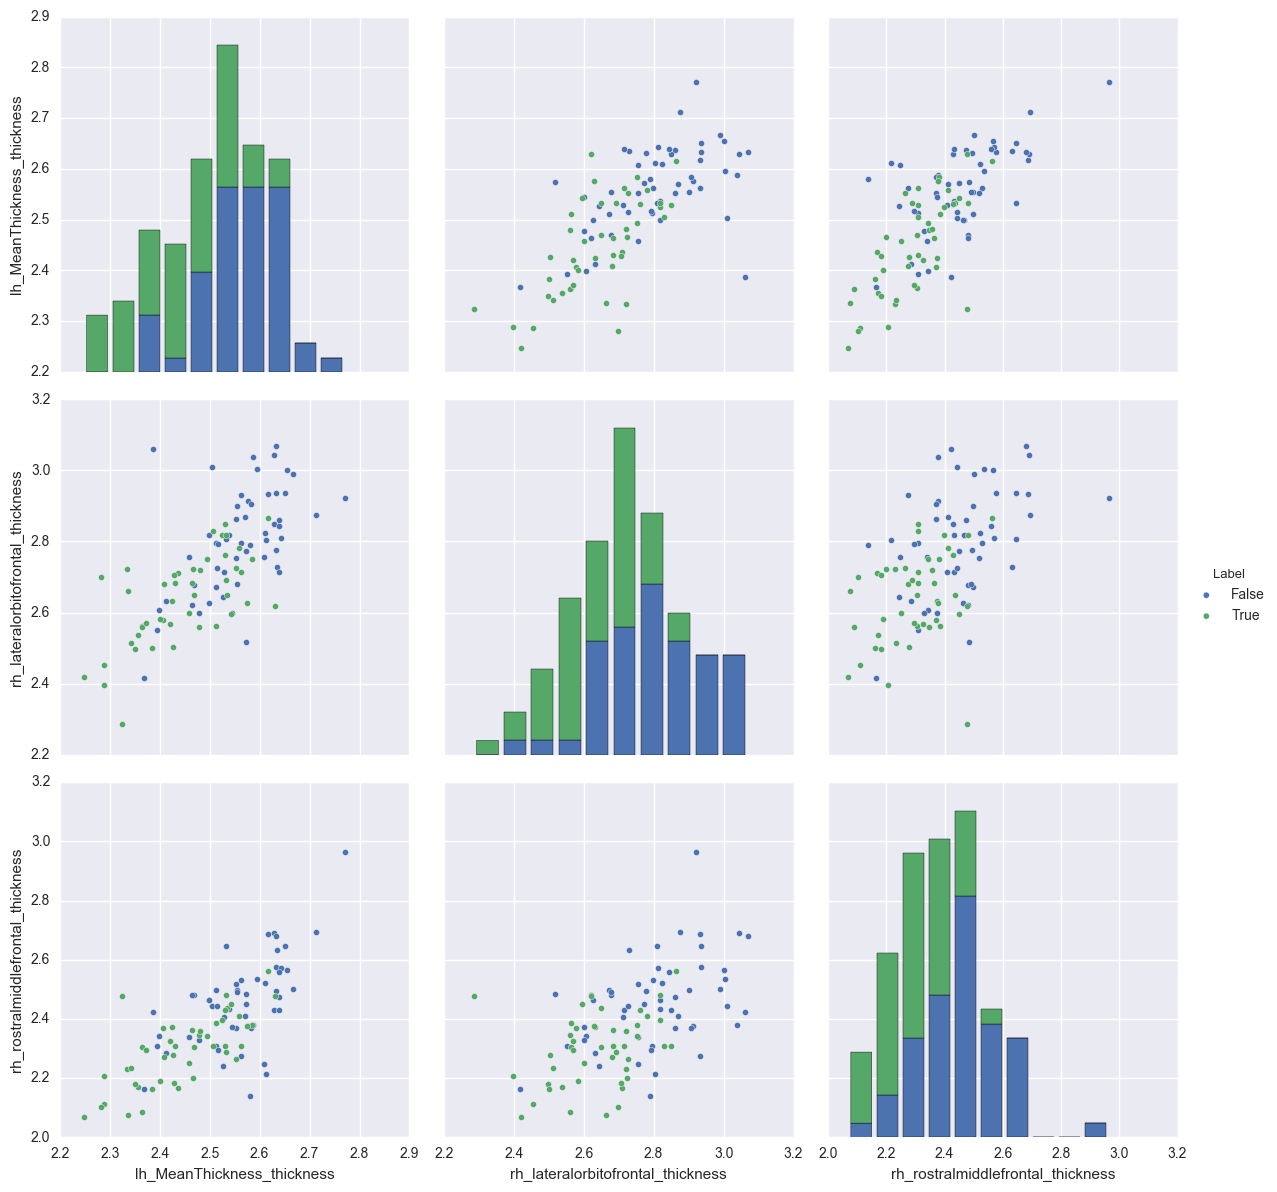

Pairplot for 3 best features thickness in Destrieux:


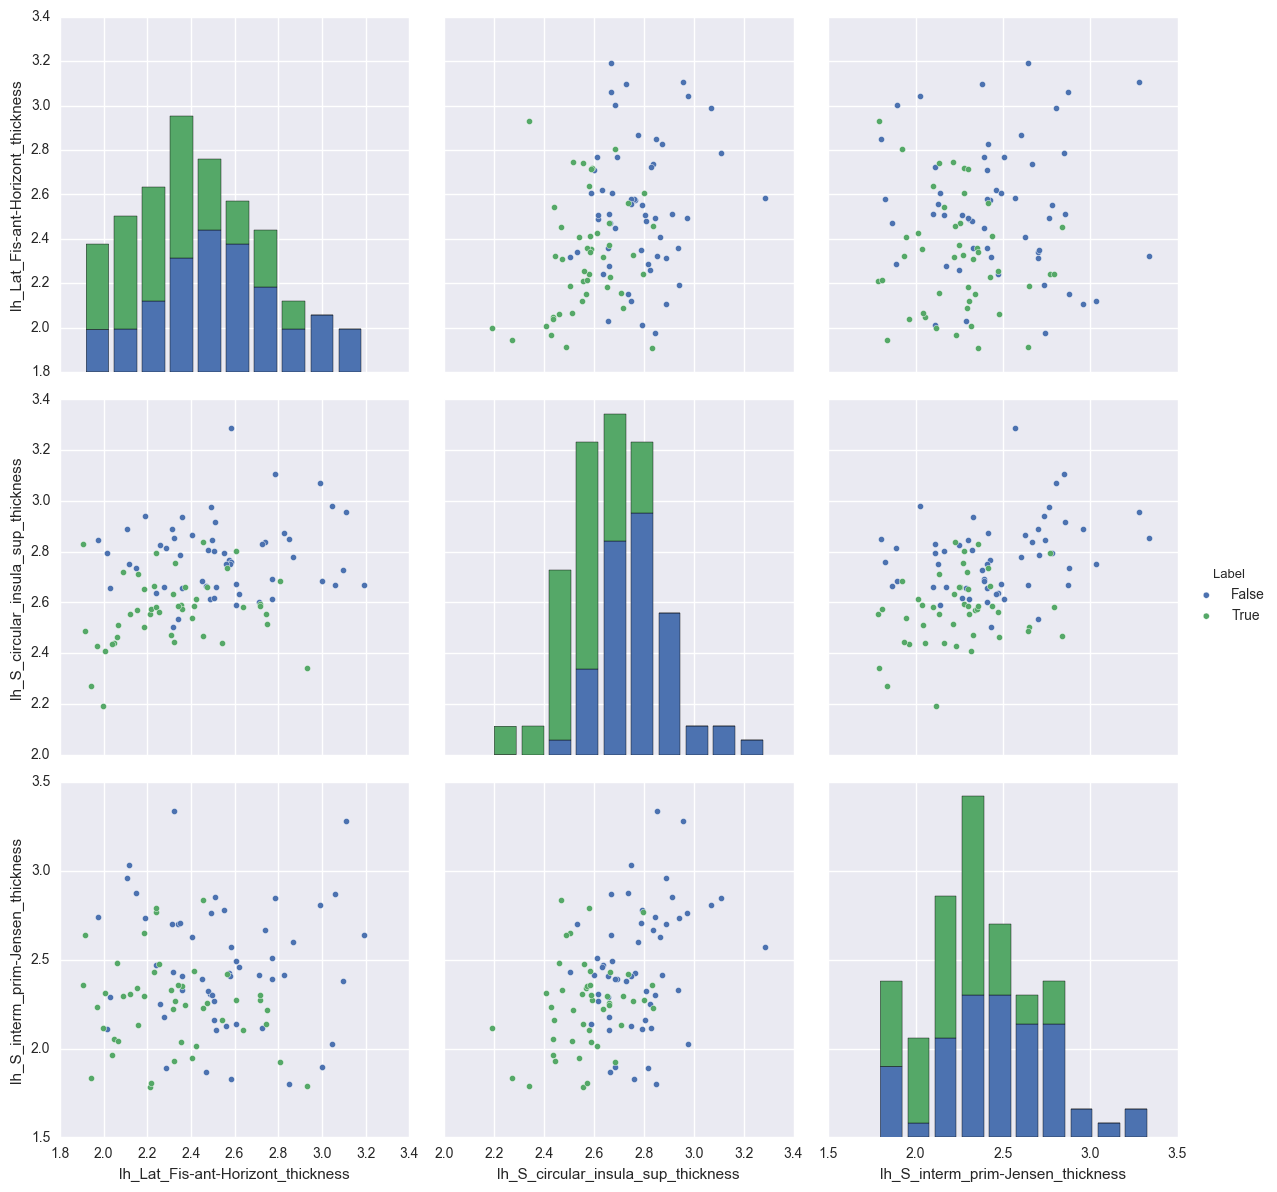

In [50]:
data_th = {}
features_to_plot_th = {}
for atlas in [desik, destr]:
    data_th[atlas] = X[atlas].copy()
    print('Pairplot for 3 best features thickness in {}:'.format(atlas))
    features_to_plot_th[atlas] = df_coef_th_first_20[atlas].key.values[:3]
    data_th[atlas]['Label'] = y[atlas]
    sns.pairplot(data = data_th[atlas], hue = 'Label', vars = data_th[atlas][features_to_plot_th[atlas]], size = 4)
    sns.plt.show()

## Поиск больных, не поддающихся классификации

In [48]:
def predict_proba_df(clf, X, y, params, random_states, clf_name = None):
    y_pred = [np.zeros((len(y[y==i]),len(random_states)+4)) for i in range(2)]
    result = list()
    for idx, rs in enumerate(random_states):
        cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = rs)
        if clf_name == 'LogReg':
            clf.set_params(logisticregressioncv__cv = cv, logisticregressioncv__n_jobs=-1)
        elif clf_name == 'SVC':
            clf.set_params(gridsearchcv__estimator__random_state = rs)
        y_pred_proba = cross_val_predict(clf, X[params], y, cv=cv, method='predict_proba')
        for i in range(2):
            y_pred[i][:,idx] = y_pred_proba[:,i][y==i]
    
    for i in range(2):
        y_pred[i][:,-4] = y_pred[i][:,:-4].max(axis = 1)
        y_pred[i][:,-3] = y_pred[i][:,:-4].min(axis = 1)
        y_pred[i][:,-2] = y_pred[i][:,:-4].mean(axis = 1)
        y_pred[i][:,-1] = y_pred[i][:,:-4].std(axis = 1)

        result.append(pd.DataFrame(data = y_pred[i][:,:], index = X[y==i].index, 
                          columns=random_states+['proba_max','proba_min','proba_mean','proba_std']))
    
    return result

def logreg_predict_proba(X, y, atlas, params, n_dim, prime_numbers):
    return predict_proba_df(make_pipeline(StandardScaler(), LogisticRegressionCV(Cs = 30)), 
                            X[atlas], y[atlas], params[atlas], prime_numbers, clf_name='LogReg')

def svc_predict_proba(X, y, atlas, params, n_dim, prime_numbers):
    C_range = np.logspace(-5, 5, 21)
    gamma_range = np.logspace(-13, 4, 17)
    param_grid = dict(gamma=gamma_range, C=C_range)
    cv=StratifiedKFold(n_splits=kfold_num, shuffle=True)
    
    clf = make_pipeline(StandardScaler(), PCA(n_components = n_dim), 
                        GridSearchCV(SVC(probability=True), param_grid=param_grid, scoring= "accuracy", cv=cv, n_jobs=-1))
    return predict_proba_df(clf, X[atlas], y[atlas], params[atlas], prime_numbers, clf_name = 'SVC')

In [55]:
def merge_to_atlas(atlas, param_range, clf_range, condition, col_to_merge, dropna_param = False, dropna = False):
    f_param = []
    for param in param_range:
        f_normal = []
        f_sch = []
        for clf in clf_range:
            f = normal[atlas][param][clf][col_to_merge]
            f = f.query(condition)
            f_normal.append(f)
            f = sch[atlas][param][clf][col_to_merge]
            f = f.query(condition)
            f_sch.append(f)
        
        f = pd.concat([pd.concat(f_normal, axis = 1), pd.concat(f_sch, axis = 1)], axis = 0)
        if dropna_param:
            f = f.dropna()
        f_param.append(f)
    res = pd.concat(f_param, axis = 1)
    if dropna:
        res = res.dropna()
    columns = pd.MultiIndex.from_product([[atlas],param_range, clf_range, col_to_merge])
    res.columns = columns
    return res

In [50]:
normal = {}
sch = {}
normal_full = {}
sch_full = {}
normal_order = {}
sch_order = {}
n_dim = 10
param_names = ['all', 'thickness']
clfs = [logreg_predict_proba, svc_predict_proba]
clf_names = ['LogReg', 'SVC']

In [51]:
#Считываем из файла, в котором все посчитано 
for atlas in [desik, destr, yeo7, yeo17]:
    normal_full[atlas], sch_full[atlas] = {}, {}
    for i, params in enumerate([all_params, thickness_idx]):
        normal_full[atlas][param_names[i]], sch_full[atlas][param_names[i]] = {}, {}
        for k, clf in enumerate(clfs):
            normal_full[atlas][param_names[i]][clf_names[k]] = pd.read_csv(atlas+'_norm_full_'+param_names[i]+'_'+clf_names[k]+'.csv', 
                                                                 index_col='Unnamed: 0')
            sch_full[atlas][param_names[i]][clf_names[k]] = pd.read_csv(atlas+'_sch_full_'+param_names[i]+'_'+clf_names[k]+'.csv',
                                                             index_col='Unnamed: 0')

In [ ]:
# Считаем и пишем в файл, считается час на моем компьютере

'''for atlas in [desik, destr, yeo7, yeo17]:
    normal_full[atlas], sch_full[atlas] = {}, {}
    for i, params in enumerate([all_params, thickness_idx]):
        normal_full[atlas][param_names[i]], sch_full[atlas][param_names[i]] = {}, {}
        for k, clf in enumerate(clfs):
            normal_full[atlas][param_names[i]][clf_names[k]], sch_full[atlas][param_names[i]][clf_names[k]] = clf(X, y, atlas, 
                                                                                                       params, n_dim,
                                                                                                        prime_numbers)
            hour = list(time.localtime())[3]
            minute = list(time.localtime())[4]
            sec = list(time.localtime())[5]
            print('{} {} {} have finished at {:02d}:{:02d}:{:02d} '.format(atlas, param_names[i], clf_names[k], 
                                                                           hour, minute, sec))

for atlas in [desik, destr, yeo7, yeo17]:
    for i, params in enumerate([all_params, thickness_idx]):
        for k, clf in enumerate(clfs):
            normal_full[atlas][param_names[i]][clf_names[k]].to_csv(atlas+'_norm_full_'+param_names[i]+'_'+clf_names[k]+'.csv')
            sch_full[atlas][param_names[i]][clf_names[k]].to_csv(atlas+'_sch_full_'+param_names[i]+'_'+clf_names[k]+'.csv')'''

In [52]:
# Разделяем данные
for atlas in [desik, destr, yeo7, yeo17]:
    normal[atlas], sch[atlas], normal_order[atlas], sch_order[atlas] = {}, {}, {}, {}
    for i, params in enumerate([all_params, thickness_idx]):
        normal[atlas][param_names[i]], sch[atlas][param_names[i]], normal_order[atlas][param_names[i]], sch_order[atlas][param_names[i]] = {}, {}, {}, {}
        for k, clf in enumerate(clfs):
            normal[atlas][param_names[i]][clf_names[k]] = normal_full[atlas][param_names[i]][clf_names[k]].drop([str(k) for k in prime_numbers], axis = 1)
            normal_order[atlas][param_names[i]][clf_names[k]] = normal_full[atlas][param_names[i]][clf_names[k]].drop(['proba_max','proba_min','proba_mean','proba_std'], axis = 1)
            sch[atlas][param_names[i]][clf_names[k]] = sch_full[atlas][param_names[i]][clf_names[k]].drop([str(k) for k in prime_numbers], axis = 1)
            sch_order[atlas][param_names[i]][clf_names[k]] = sch_full[atlas][param_names[i]][clf_names[k]].drop(['proba_max','proba_min','proba_mean','proba_std'], axis = 1)

In [53]:
def order_matrix(df1, df2, random_states):
    res = np.zeros((df1.index.size,len(random_states)+2))
    for i, rs in enumerate(random_states):
        for j, proba in enumerate(df1[str(rs)]):
            res[j,i] = df1[df1[str(rs)]>1-proba][str(rs)].count()
    res[:,-2] = res[:,:-2].mean(axis = 1)
    res[:,-1] = res[:,:-2].std(axis = 1)
    return res[:,-2:]

def order_df(dict1, dict2, atlases, params_range, clf_range, random_states):
    arr = []
    for atlas in atlases:
        for param in params_range:
            matrix = np.zeros((dict1[atlas][param][clf_range[0]].index.size,2))
            for clf in clf_range:
                temp = order_matrix(dict1[atlas][param][clf], dict2[atlas][param][clf], random_states)
                matrix[:,0] = (matrix[:,0]+temp[:,0])
                matrix[:,1] = (matrix[:,1]+temp[:,1])
            matrix[:,0] = matrix[:,0]/len(clf_range)
            matrix[:,1] = matrix[:,1]/np.sqrt(len(clf_range))
            arr.append(matrix)
    cols = pd.MultiIndex.from_product([atlases,params_range,['order_mean', 'order_std']])
    return pd.DataFrame(data = np.hstack((z for z in arr)), index = dict1[atlas][param][clf].index, columns = cols)

In [54]:
sch_order_df = order_df(sch_order, normal_order, [desik, destr, yeo7, yeo17], param_names,clf_names,prime_numbers)
normal_order_df = order_df(normal_order, sch_order, [desik, destr, yeo7, yeo17], param_names,clf_names,prime_numbers)

### Гистограммы распределений предсказаний

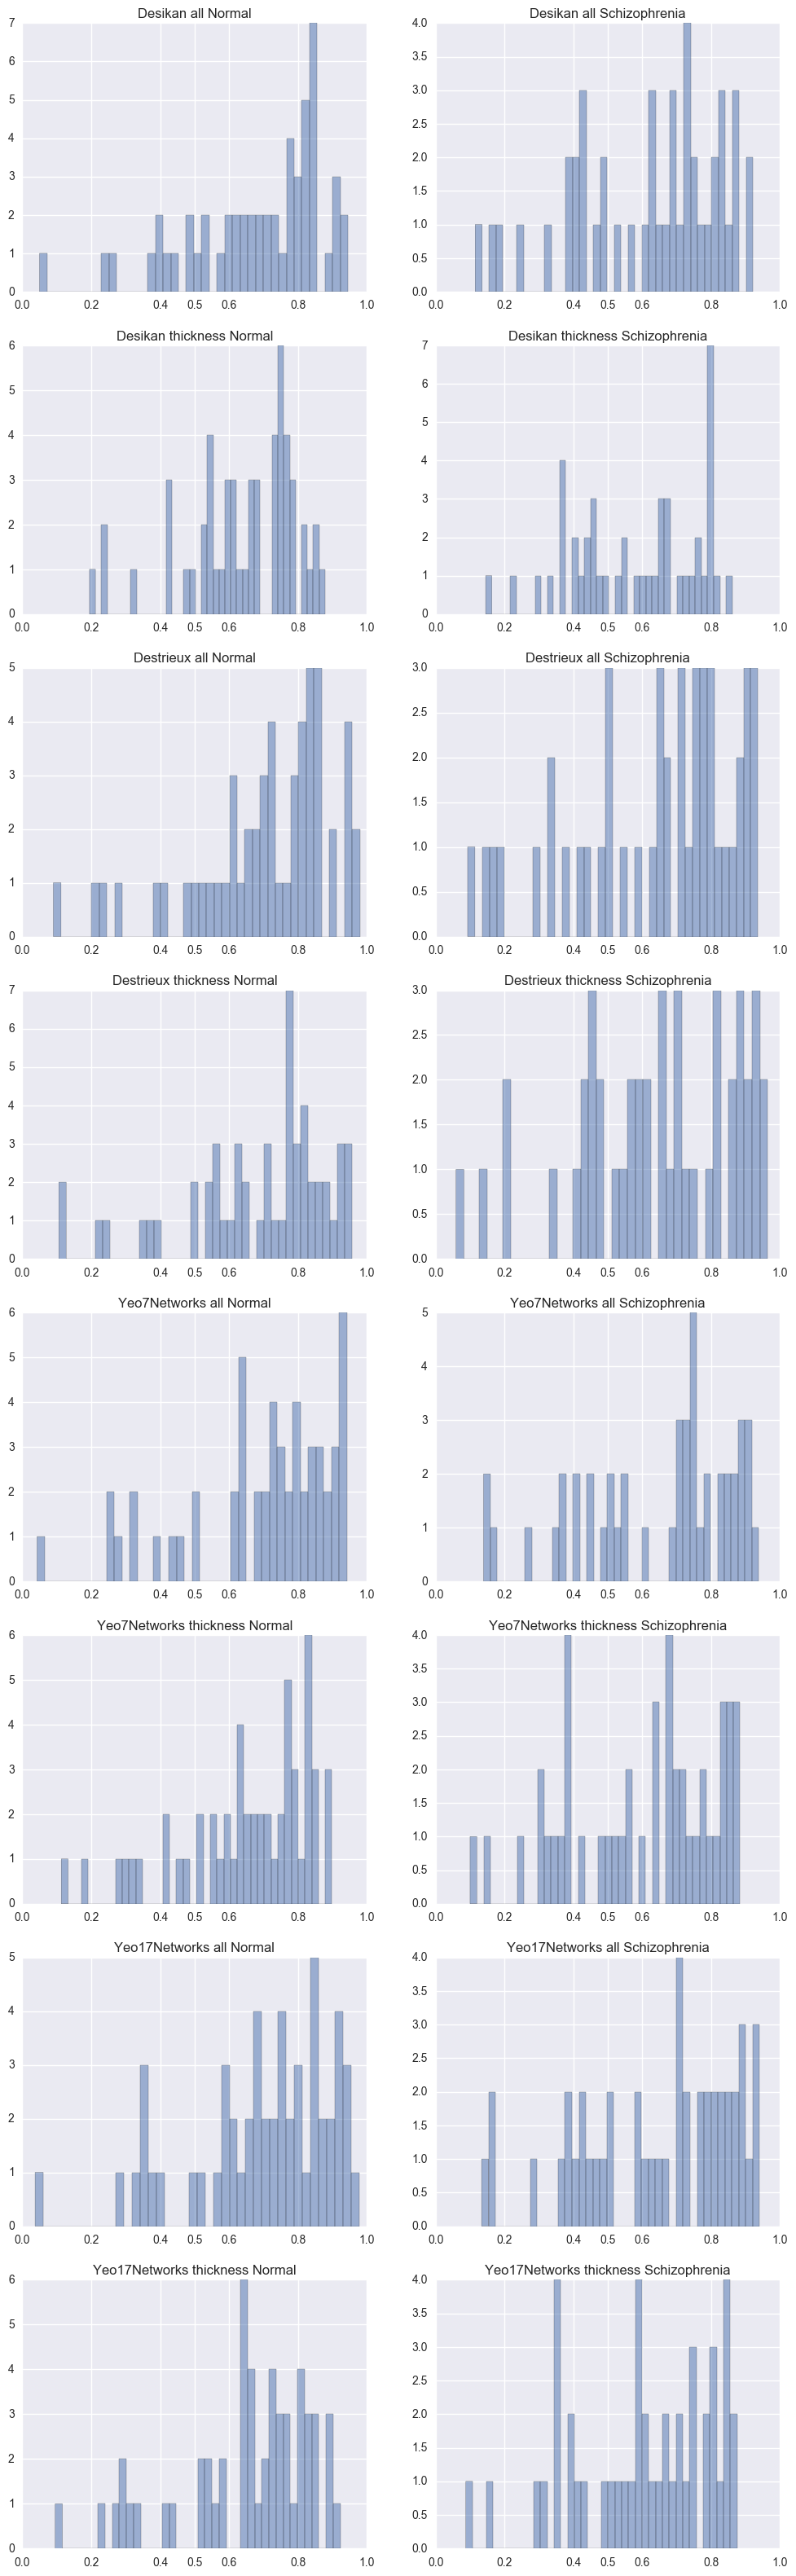

In [59]:
target_names = ['Normal', 'Schizophrenia']
fig = plt.figure(figsize = (12,40))
plot_number = 1
for atlas in [desik, destr, yeo7, yeo17]:
    for params in param_names:
        for idx, target in enumerate([normal, sch]): 
            ax = fig.add_subplot(8,2,plot_number)
            plot_number+=1
            ax.hist((target[atlas][params]['LogReg']['proba_mean']+target[atlas][params]['SVC']['proba_mean'])/2, bins = 40, alpha = 0.5)
            #ax.hist(1-target[atlas][params]['LogReg']['proba_mean'], bins = 40, alpha = 0.5, label = 'LogReg')
            ax.set_title('{:s} {:s} {:s}'.format(atlas, params, target_names[idx]))
            ax.set_xticks([0,0.2,0.4,0.5,0.6,0.8,1])

In [60]:
#делаем мега табличку
norm_av = {}
sch_av = {}
for atlas in atlases:
    norm_av[atlas] = {}
    sch_av[atlas] = {}
    for param in param_names:
        norm_av[atlas][param] = sum([normal[atlas][param][clf] for clf in clf_names])
        sch_av[atlas][param] = sum([sch[atlas][param][clf] for clf in clf_names])
        for df in [norm_av[atlas][param], sch_av[atlas][param]]:
            df['proba_mean'] = df['proba_mean']/len(clf_names)
            df['proba_std'] = df['proba_std']/np.sqrt(len(clf_names))
            df.drop(['proba_max', 'proba_min'], axis = 1, inplace = True)

sch_df = sch_order_df.copy()
normal_df = normal_order_df.copy()

for atlas in atlases:
    for param in param_names:
        for proba in ['proba_mean', 'proba_std']: 
            sch_df[(atlas,param,proba)] = sch_av[atlas][param][proba]
            normal_df[(atlas,param,proba)] = norm_av[atlas][param][proba]

In [84]:
def subindex(full, part):
    res = []
    for a,b in enumerate(full.index):
        for c in part.index:
            if b==c:
                res.append(a+1)
    return res

C:\Users\Николай\Anaconda3\lib\site-packages\ipykernel\kernelbase.py:390: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


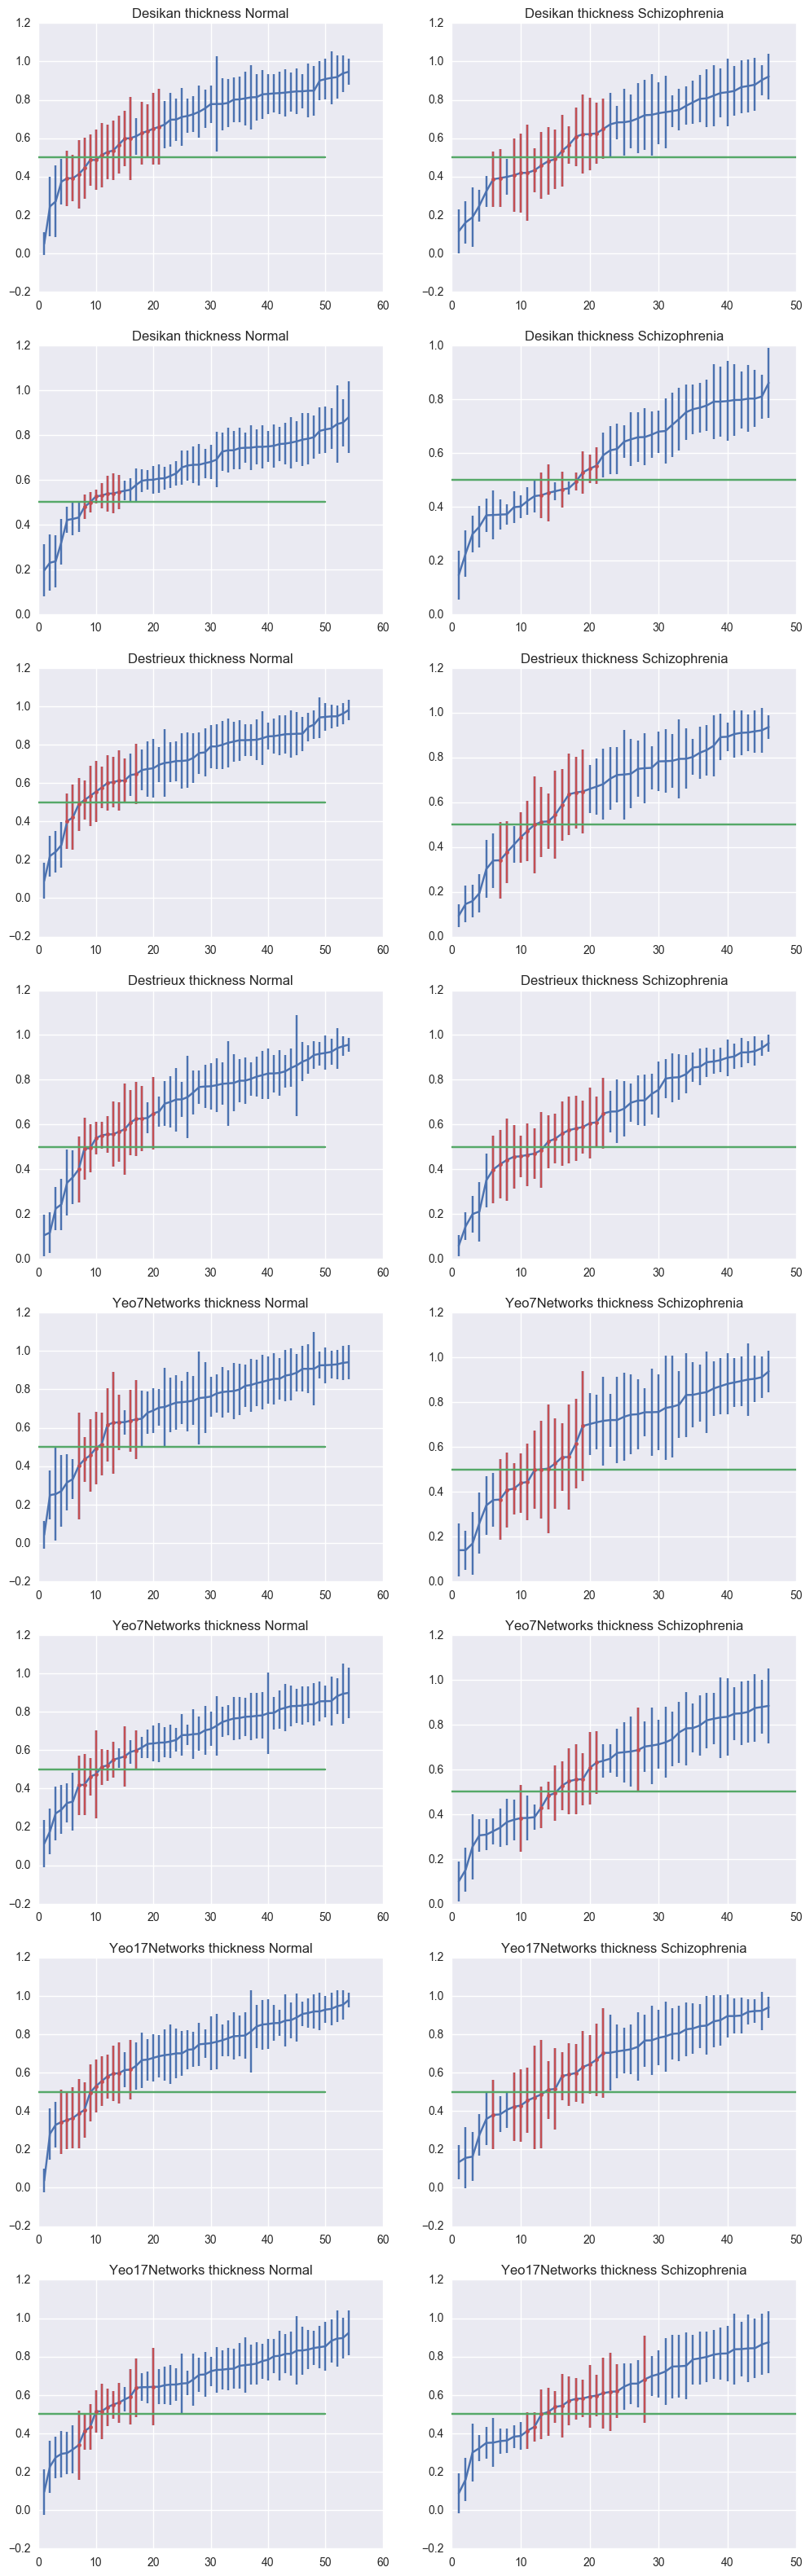

In [86]:
target_names = ['Normal', 'Schizophrenia']
fig = plt.figure(figsize = (12,40))
plot_number = 1
for atlas in [desik, destr, yeo7, yeo17]:
    for param in param_names:
        for idx, target in enumerate([normal_df, sch_df]): 
            ax = fig.add_subplot(8,2,plot_number)
            plot_number+=1
            ax.errorbar(np.array(range(1,target.index.size+1)), target[(atlas,param)].sort_values('proba_mean').proba_mean,
                    yerr = target[(atlas,param)].sort_values('proba_mean').proba_std)
            ax.plot(np.linspace(0,50), 50*[0.5])
            middle = target[(atlas,param)].query('proba_mean-proba_std<=0.5&proba_mean>0.5|proba_mean<=0.5&proba_mean+proba_std>0.5').sort_values('proba_mean')
            ax.errorbar(subindex(target[(atlas,param)].sort_values('proba_mean'), middle), middle.proba_mean, yerr=middle.proba_std, fmt = '.')
            #ax.hist((target[atlas][params]['LogReg']['proba_mean']+target[atlas][params]['SVC']['proba_mean'])/2, bins = 40, alpha = 0.5)
            #ax.hist(1-target[atlas][params]['LogReg']['proba_mean'], bins = 40, alpha = 0.5, label = 'LogReg')
            ax.set_title('{:s} {:s} {:s}'.format(atlas, params, target_names[idx]))

In [90]:
conf_err = {}
for atlas in atlases:
    conf_err[atlas] = {}
    for param in param_names:
        conf_err[atlas][param] = {}
        for idx, target in enumerate([normal_df, sch_df]):
            conf_err[atlas][param][target_names[idx]] = target[(atlas, param)].query('proba_mean<0.5&proba_mean+proba_std<0.5')

C:\Users\Николай\Anaconda3\lib\site-packages\ipykernel\kernelbase.py:390: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [177]:
def merge_(err, atlases, param_range, col_to_merge):
    frames = {}
    res = {}
    for tn in target_names:
        frames[tn] = []
        for atlas in atlases:
            for param in param_range:
                frames[tn].append(err[atlas][param][tn])
        res[tn] = pd.concat(frames[tn], axis = 1)
    res_ = pd.concat([res[tn] for tn in target_names], axis = 0)
    cols = pd.MultiIndex.from_product([atlases,param_range, col_to_merge])
    res_.columns = cols
    return res_

In [102]:
merged_conf_full = merge_(conf_err, atlases, param_names, ['order_mean','order_std','proba_mean','proba_std'])

In [108]:
frames = []
for atlas in atlases:
    frames.append(pd.DataFrame(data = merged_conf_full[atlas].dropna().index, 
                                      index = merged_conf_full[atlas].dropna().index, 
                                      columns = [atlas]))

In [115]:
df_conf = pd.concat(frames, axis=1)
print('Люди, которых PCA(ndim = 10) + SVC и LogisticRegreccion всегда классифицируют неверно \nпри обучении на разных атласах и разных наборах признаков.')
df_conf.fillna('')

Люди, которых PCA(ndim = 10) + SVC и LogisticRegreccion всегда классифицируют неверно 
при обучении на разных атласах и разных наборах признаков.


,Desikan,Destrieux,Yeo7Networks,Yeo17Networks
NORM06,NORM06,NORM06,NORM06,NORM06
NORM24,NORM24,NORM24,NORM24,NORM24
NORM29,,,NORM29,NORM29
NORM43,NORM43,NORM43,,
NORM52,,NORM52,NORM52,
SCH04,SCH04,,SCH04,SCH04
SCH17,,,,SCH17
SCH19,SCH19,SCH19,SCH19,SCH19
SCH29,SCH29,SCH29,SCH29,SCH29
SCH36,SCH36,SCH36,SCH36,SCH36


### Посчитаем для них kDN
$$kDN(x) = \dfrac{\mid \{y:y\in kNN(x)\; \& \; t(y)\neq t(x)\}\mid}{k}$$

In [116]:
from sklearn.neighbors import NearestNeighbors

In [140]:
nn = {}

In [143]:
def kdn(atlas, index, neigh):
    nn[atlas] =  NearestNeighbors(n_neighbors=neigh, n_jobs = -1, metric = 'euclidean')
    nn[atlas].fit(X_scaled_pd[atlas])
    m = np.sign(nn[atlas].kneighbors(X_scaled_pd[atlas].loc[index,:], neigh, return_distance=False)+1-54.5)
    kdn = np.zeros(index.size)
    for k, idx in enumerate(index):
        if m[k,0]==-1:
            m_=(m+1)/2
            kdn[k] = sum(m_[k,:])/neigh
        else:
            m_ = (m-1)/2
            kdn[k] = sum(m_[k,:])/neigh
    return np.abs(kdn)

In [172]:
matr = np.zeros((df_conf.index.size, len(atlases)))
for j, atlas in enumerate(atlases):
    for i, idx in enumerate(df_conf.index):
        matr[i,j] = np.array([kdn(atlas, df_conf.index, n)[i] for n in range(4,10)]).mean()

In [173]:
matr = matr*100
matr = matr.astype(int)/100

In [174]:
kdn_df = pd.DataFrame(data = matr, columns  = atlases, index=df_conf.index )
pd.concat([df_conf, kdn_df], axis = 1).fillna('')

,Desikan,Destrieux,Yeo7Networks,Yeo17Networks,Desikan,Destrieux,Yeo7Networks,Yeo17Networks
NORM06,NORM06,NORM06,NORM06,NORM06,0.83,0.83,0.83,0.83
NORM24,NORM24,NORM24,NORM24,NORM24,0.54,0.64,0.48,0.60
NORM29,,,NORM29,NORM29,0.06,0.16,0.16,0.06
NORM43,NORM43,NORM43,,,0.33,0.57,0.19,0.45
NORM52,,NORM52,NORM52,,0.19,0.44,0.44,0.35
SCH04,SCH04,,SCH04,SCH04,0.83,0.71,0.67,0.67
SCH17,,,,SCH17,0.64,0.24,0.64,0.74
SCH19,SCH19,SCH19,SCH19,SCH19,0.75,0.81,0.83,0.83
SCH29,SCH29,SCH29,SCH29,SCH29,0.60,0.70,0.64,0.60
SCH36,SCH36,SCH36,SCH36,SCH36,0.54,0.41,0.54,0.66


In [175]:
susp_err = {}
for atlas in atlases:
    susp_err[atlas] = {}
    for param in param_names:
        susp_err[atlas][param] = {}
        for idx, target in enumerate([normal_df, sch_df]):
            susp_err[atlas][param][target_names[idx]] = target[(atlas, param)].query('proba_mean-proba_std<=0.5&proba_mean>0.5|proba_mean<=0.5&proba_mean+proba_std>0.5')

C:\Users\Николай\Anaconda3\lib\site-packages\ipykernel\kernelbase.py:390: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


In [178]:
merged_susp_full = merge_(susp_err, atlases, param_names, ['order_mean','order_std','proba_mean','proba_std'])

In [179]:
frames = []
for atlas in atlases:
    frames.append(pd.DataFrame(data = merged_susp_full[atlas].dropna().index, 
                                      index = merged_susp_full[atlas].dropna().index, 
                                      columns = [atlas]))

### Рассмотрим оставшихся людей (красные на графиках)

In [180]:
df_susp = pd.concat(frames, axis=1)
print('Люди, которых PCA(ndim = 10) + SVC и LogisticRegreccion всегда классифицируют неверно \nпри обучении на разных атласах и разных наборах признаков.')
df_susp.fillna('')

Люди, которых PCA(ndim = 10) + SVC и LogisticRegreccion всегда классифицируют неверно 
при обучении на разных атласах и разных наборах признаков.


,Desikan,Destrieux,Yeo7Networks,Yeo17Networks
NORM05,,NORM05,,NORM05
NORM16,NORM16,,NORM16,NORM16
NORM23,NORM23,NORM23,,
NORM25,NORM25,NORM25,NORM25,
NORM27,,NORM27,,
NORM30,,NORM30,,NORM30
NORM39,NORM39,,,
NORM45,NORM45,NORM45,NORM45,NORM45
NORM47,,NORM47,,
NORM49,,,,NORM49


In [181]:
matr = np.zeros((df_susp.index.size, len(atlases)))
for j, atlas in enumerate(atlases):
    for i, idx in enumerate(df_susp.index):
        matr[i,j] = np.array([kdn(atlas, np.array([idx]), n) for n in range(4,10)]).mean()

In [182]:
matr = matr*100
matr = matr.astype(int)/100

In [192]:
kdn_df_susp = pd.DataFrame(data = matr, columns  = atlases, index=df_susp.index )
df_susp_kdn = pd.concat([df_susp, kdn_df_susp], axis = 1).fillna('')
print('Люди, которых PCA(ndim = 10) + SVC и LogisticRegreccion иногда классифицируют неверно \nпри обучении на разных атласах и разных наборах признаков.')
df_susp_kdn

Люди, которых PCA(ndim = 10) + SVC и LogisticRegreccion иногда классифицируют неверно 
при обучении на разных атласах и разных наборах признаков.


,Desikan,Destrieux,Yeo7Networks,Yeo17Networks,Desikan,Destrieux,Yeo7Networks,Yeo17Networks
NORM05,,NORM05,,NORM05,0.49,0.35,0.58,0.54
NORM16,NORM16,,NORM16,NORM16,0.16,0.26,0.29,0.20
NORM23,NORM23,NORM23,,,0.52,0.51,0.21,0.32
NORM25,NORM25,NORM25,NORM25,,0.35,0.22,0.18,0.38
NORM27,,NORM27,,,0.50,0.34,0.25,0.33
NORM30,,NORM30,,NORM30,0.43,0.28,0.28,0.27
NORM39,NORM39,,,,0.16,0.29,0.01,0.00
NORM45,NORM45,NORM45,NORM45,NORM45,0.43,0.46,0.10,0.43
NORM47,,NORM47,,,0.27,0.47,0.06,0.16
NORM49,,,,NORM49,0.27,0.44,0.38,0.46


In [189]:
df_susp_small = pd.concat([df_susp[[desik,destr]].dropna(), df_susp[[yeo7,yeo17]].dropna()], axis=1).fillna('')

In [193]:
print('Люди, которых PCA(ndim = 10) + SVC и LogisticRegreccion иногда классифицируют неверно \nпри обучении на разных атласах и разных наборах признаков.\nПересечение по парам атласов')
df_susp_kdn.loc[df_susp_small.index,:]

Люди, которых PCA(ndim = 10) + SVC и LogisticRegreccion иногда классифицируют неверно 
при обучении на разных атласах и разных наборах признаков.
Пересечение по парам атласов


,Desikan,Destrieux,Yeo7Networks,Yeo17Networks,Desikan,Destrieux,Yeo7Networks,Yeo17Networks
NORM16,NORM16,,NORM16,NORM16,0.16,0.26,0.29,0.20
NORM23,NORM23,NORM23,,,0.52,0.51,0.21,0.32
NORM25,NORM25,NORM25,NORM25,,0.35,0.22,0.18,0.38
NORM45,NORM45,NORM45,NORM45,NORM45,0.43,0.46,0.10,0.43
SCH06,,SCH06,SCH06,SCH06,0.67,0.57,0.66,0.72
SCH21,SCH21,SCH21,,,0.35,0.72,0.81,0.74
SCH23,,SCH23,SCH23,SCH23,0.30,0.33,0.35,0.30
SCH26,,SCH26,SCH26,SCH26,0.46,0.34,0.74,0.65
SCH30,,SCH30,SCH30,SCH30,0.54,0.73,0.77,0.64
SCH40,SCH40,SCH40,,,0.70,0.57,0.77,0.83


- normal
    - well classified    0 - NoWeCl
    - wrong in average  -2 - NoWrAv
    - wrong max         -3 - NoWrMa
- SCH
    - well classified    1 - ScWeCl
    - wrong in average   2 - ScWrAv
    - wrong max          3 - ScWrMa

In [158]:
mean_err = {}
#max_err = {}

for atlas in atlases:
    #max_err[atlas] = merge_to_atlas(atlas, param_names, clf_names, 'proba_max', 0.5, ['proba_max', 'proba_mean'], dropna=False)
    mean_err[atlas] = merge_to_atlas(atlas, param_names, clf_names, 
                                     'proba_mean-proba_std<=0.5&proba_mean>0.5|proba_mean<=0.5', ['proba_mean', 'proba_std'], dropna=False)

In [131]:
def make_label(x):
    return {x==-3: 'NoWrMa', x==-2: 'NoWrAv', x==0: 'NoWeCl', x==1: 'ScWeCl', x==2: 'ScWrAv', x==3:'ScWrMa'}[True]

In [132]:
label = {}
for atlas in atlases:
    label[atlas] = np.array(y[atlas], dtype=int)
    label[atlas] += np.array([any(map(lambda i: mean_err[atlas].dropna().index[i]==idx and 'NORM' in idx, 
                          range(mean_err[atlas].dropna().index.size))) for idx in X[atlas].index], dtype=int)*(-2)
    label[atlas] += np.array([any(map(lambda i: max_err[atlas].dropna().index[i]==idx and 'NORM' in idx, 
                          range(max_err[atlas].dropna().index.size))) for idx in X[atlas].index], dtype=int)*(-1)
    label[atlas] += np.array([any(map(lambda i: mean_err[atlas].dropna().index[i]==idx and 'SCH' in idx, 
                          range(mean_err[atlas].dropna().index.size))) for idx in X[atlas].index], dtype=int)*1
    label[atlas] += np.array([any(map(lambda i: max_err[atlas].dropna().index[i]==idx and 'SCH' in idx, 
                          range(max_err[atlas].dropna().index.size))) for idx in X[atlas].index], dtype=int)*1
    label[atlas] = [make_label(i) for i in label[atlas]]

In [57]:
#frame_max = []
frame_mean = []
for atlas in atlases:
    for param in param_names:
 #       frame_max.append(pd.DataFrame(data = max_err[atlas][(atlas,param)].dropna().index, 
  #                                    index = max_err[atlas][(atlas,param)].dropna().index, 
   #                                   columns = [atlas]))
        frame_mean.append(pd.DataFrame(data = mean_err[atlas][(atlas,param)].dropna().index, 
                                      index = mean_err[atlas][(atlas,param)].dropna().index, 
                                      columns = [atlas]))
#max_all = pd.concat(frame_max, axis = 1)
#max_all.columns = pd.MultiIndex.from_product([['max < 0.5'], atlases, param_names]) 
mean_all = pd.concat(frame_mean, axis = 1)
mean_all.columns = pd.MultiIndex.from_product([['mean < 0.5'], atlases, param_names])

In [134]:
print('Люди, которых PCA(ndim = 10) + SVC и LogisticRegreccion всегда классифицируют неверно \nпри обучении на разных атласах и разных наборах признаков.')
max_all.fillna(' ')

Люди, которых PCA(ndim = 10) + SVC и LogisticRegreccion всегда классифицируют неверно 
при обучении на разных атласах и разных наборах признаков.


max < 0.5                                                       \
         Desikan           Destrieux           Yeo7Networks             
             all thickness       all thickness          all thickness   
NORM06    NORM06    NORM06    NORM06    NORM06       NORM06    NORM06   
NORM24    NORM24    NORM24    NORM24    NORM24       NORM24    NORM24   
NORM27              NORM27                                              
NORM29                                  NORM29                          
NORM38              NORM38                                              
NORM43              NORM43    NORM43    NORM43                 NORM43   
NORM45                                                                  
NORM52              NORM52              NORM52       NORM52             
SCH02                SCH02                                      SCH02   
SCH04      SCH04               SCH04                  SCH04     SCH04   
SCH06                SCH06                                              
SCH17                                                           SCH17   
SCH19      SCH19     SCH19     SCH19     SCH19        SCH19     SCH19   
SCH21                                                 SCH21             
SCH24                SCH24                                              
SCH27                                                           SCH27   
SCH29      SCH29     SCH29     SCH29     SCH29        SCH29     SCH29   
SCH36      SCH36     SCH36     SCH36     SCH36                  SCH36   
SCH39      SCH39     SCH39                                      SCH39   
SCH45                SCH45     SCH45     SCH45                          
SCH46                                    SCH46                  SCH46   

                                
       Yeo17Networks            
                 all thickness  
NORM06        NORM06    NORM06  
NORM24                  NORM24  
NORM27                          
NORM29        NORM29            
NORM38                          
NORM43                  NORM43  
NORM45        NORM45            
NORM52                  NORM52  
SCH02                    SCH02  
SCH04                    SCH04  
SCH06                           
SCH17                    SCH17  
SCH19          SCH19     SCH19  
SCH21                           
SCH24                    SCH24  
SCH27                           
SCH29          SCH29     SCH29  
SCH36          SCH36     SCH36  
SCH39                    SCH39  
SCH45                           
SCH46                    SCH46

In [310]:
print('Люди, на которых всегда ошибаются вышеуказанные классификаторы при обучении на всех признаках либо на толщинах зон') 
print('Пересечение по всем атласам для конкретного набора признаков.')
pd.concat([max_all['max < 0.5'][[(x,'all') for x in atlases]].dropna(),
           max_all['max < 0.5'][[(x,'thickness') for x in atlases]].dropna()],
          axis = 1).fillna(' ')['Desikan']

Люди, на которых всегда ошибаются вышеуказанные классификаторы при обучении на всех признаках либо на толщинах зон
Пересечение по всем атласам для конкретного набора признаков.


,all,thickness
NORM06,NORM06,NORM06
NORM24,,NORM24
NORM43,,NORM43
SCH19,SCH19,SCH19
SCH29,SCH29,SCH29
SCH36,,SCH36


In [58]:
print('Люди, которых PCA(ndim = 10) + SVC и LogisticRegreccion в среднем классифицируют неверно \nпри обучении на разных атласах и разных наборах признаков.')
mean_all.fillna(' ')

Люди, которых PCA(ndim = 10) + SVC и LogisticRegreccion в среднем классифицируют неверно 
при обучении на разных атласах и разных наборах признаков.


mean < 0.5                                                       \
          Desikan           Destrieux           Yeo7Networks             
              all thickness       all thickness          all thickness   
NORM05     NORM05                        NORM05       NORM05             
NORM06     NORM06    NORM06    NORM06    NORM06       NORM06    NORM06   
NORM11                                                          NORM11   
NORM15                                   NORM15                          
NORM16     NORM16                                     NORM16    NORM16   
NORM17     NORM17                                                        
NORM21               NORM21                                     NORM21   
NORM23               NORM23                                              
NORM24     NORM24    NORM24    NORM24    NORM24       NORM24    NORM24   
NORM25                                   NORM25                          
NORM27     NORM27    NORM27              NORM27                 NORM27   
NORM29     NORM29    NORM29    NORM29    NORM29       NORM29    NORM29   
NORM30     NORM30    NORM30    NORM30    NORM30       NORM30    NORM30   
NORM36                                                NORM36             
NORM38     NORM38    NORM38    NORM38    NORM38                 NORM38   
NORM39               NORM39                                              
NORM43     NORM43    NORM43    NORM43    NORM43       NORM43    NORM43   
NORM45     NORM45    NORM45    NORM45                 NORM45    NORM45   
NORM49                                                                   
NORM52     NORM52    NORM52    NORM52    NORM52       NORM52    NORM52   
NORM54     NORM54                                     NORM54             
SCH02                 SCH02               SCH02                  SCH02   
SCH03                 SCH03                                      SCH03   
SCH04       SCH04     SCH04     SCH04                  SCH04     SCH04   
SCH06       SCH06     SCH06     SCH06     SCH06        SCH06     SCH06   
SCH09                                                  SCH09             
SCH13                                                                    
SCH17       SCH17     SCH17     SCH17     SCH17        SCH17     SCH17   
SCH19       SCH19     SCH19     SCH19     SCH19        SCH19     SCH19   
SCH21       SCH21     SCH21     SCH21     SCH21        SCH21     SCH21   
SCH23       SCH23               SCH23                  SCH23             
SCH24       SCH24     SCH24     SCH24     SCH24        SCH24     SCH24   
SCH26       SCH26     SCH26               SCH26        SCH26     SCH26   
SCH27       SCH27     SCH27                            SCH27     SCH27   
SCH29       SCH29     SCH29     SCH29     SCH29        SCH29     SCH29   
SCH30       SCH30     SCH30     SCH30     SCH30        SCH30     SCH30   
SCH32                 SCH32     SCH32     SCH32                  SCH32   
SCH34                 SCH34                                              
SCH36       SCH36     SCH36     SCH36     SCH36        SCH36     SCH36   
SCH38                                                  SCH38             
SCH39       SCH39     SCH39     SCH39                  SCH39     SCH39   
SCH40       SCH40     SCH40     SCH40                  SCH40     SCH40   
SCH44                                     SCH44                          
SCH45       SCH45     SCH45     SCH45     SCH45        SCH45     SCH45   
SCH46       SCH46     SCH46     SCH46     SCH46        SCH46     SCH46   

                                
       Yeo17Networks            
                 all thickness  
NORM05        NORM05            
NORM06        NORM06    NORM06  
NORM11                          
NORM15                          
NORM16        NORM16            
NORM17                          
NORM21                  NORM21  
NORM23                  NORM23  
NORM24        NORM24    NORM24  
NORM25                          
NORM27                  N

In [312]:
print('Люди, на которых в среднем ошибаются вышеуказанные классификаторы при обучении на всех признаках либо на толщинах зон. \nПересечение по всем атласам для конкретного набора признаков.')
pd.concat([mean_all['mean < 0.5'][[(x,'all') for x in atlases]].dropna(), 
           mean_all['mean < 0.5'][[(x,'thickness') for x in atlases]].dropna()], 
          axis=1).fillna(' ')['Desikan']

Люди, на которых в среднем ошибаются вышеуказанные классификаторы при обучении на всех признаках либо на толщинах зон. 
Пересечение по всем атласам для конкретного набора признаков.


,all,thickness
NORM06,NORM06,NORM06
NORM24,NORM24,NORM24
NORM29,NORM29,NORM29
NORM38,,NORM38
NORM43,NORM43,NORM43
NORM52,NORM52,NORM52
SCH02,,SCH02
SCH04,SCH04,
SCH17,SCH17,
SCH19,SCH19,SCH19


Метки различны для различных атласов (для каждого атласа выделяются люди, которых мы не смогли классифицировать, обучаясь на данном атласе)


				 Pairplot for 3 best feature thickness in Desikan:




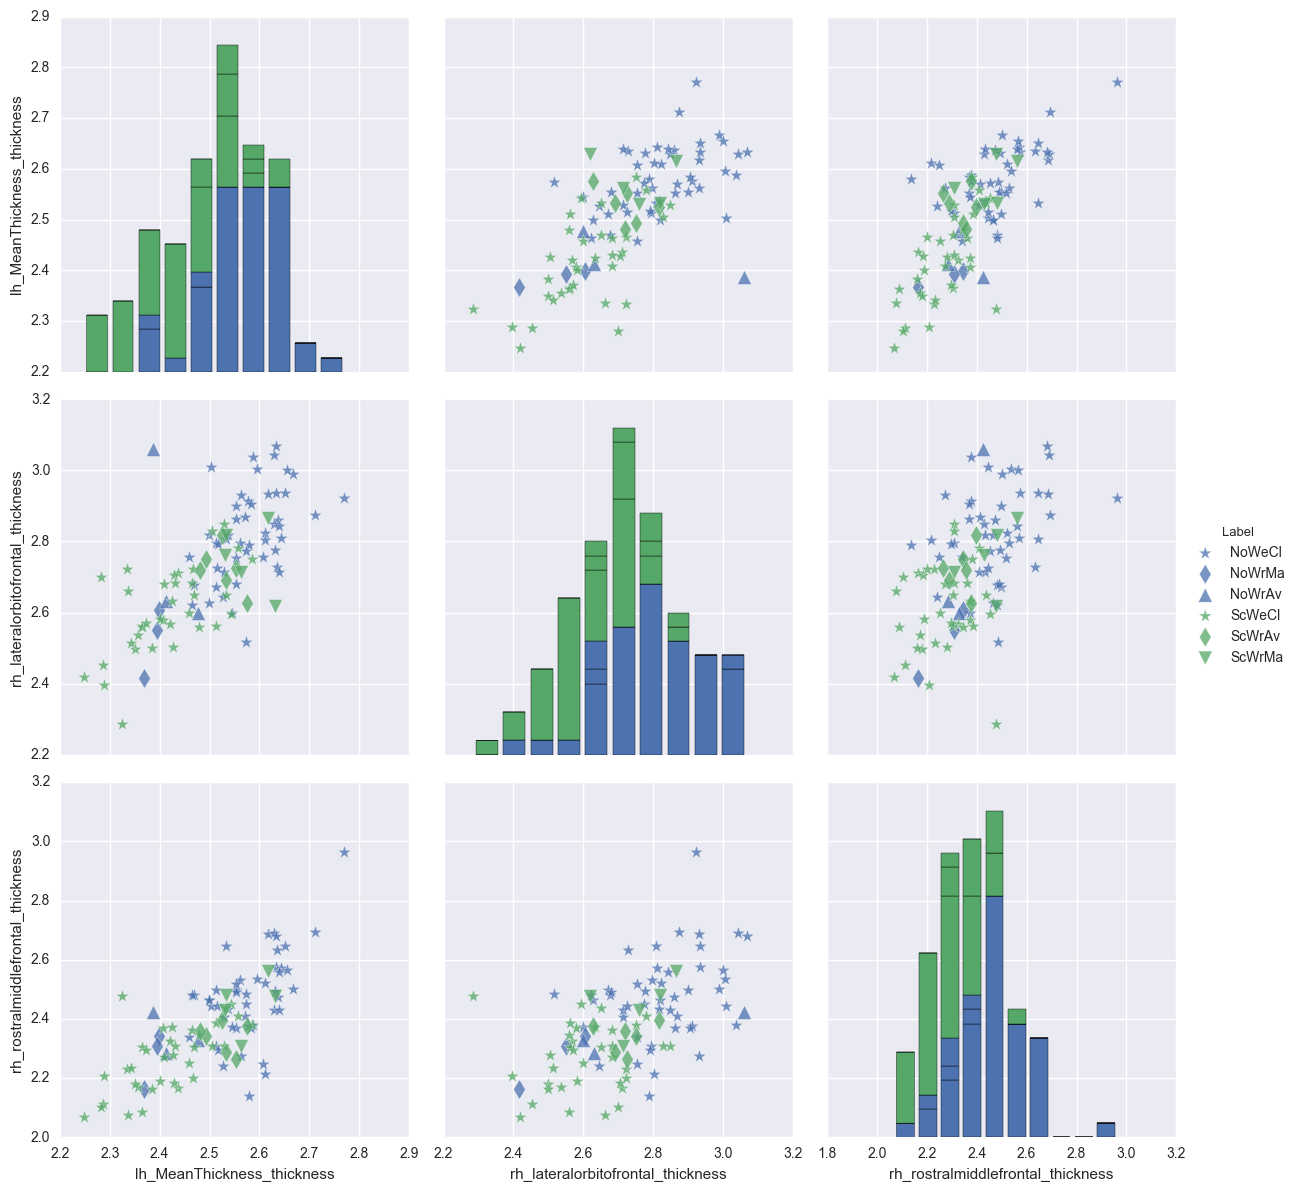



				 Pairplot for 3 best feature thickness in Destrieux:




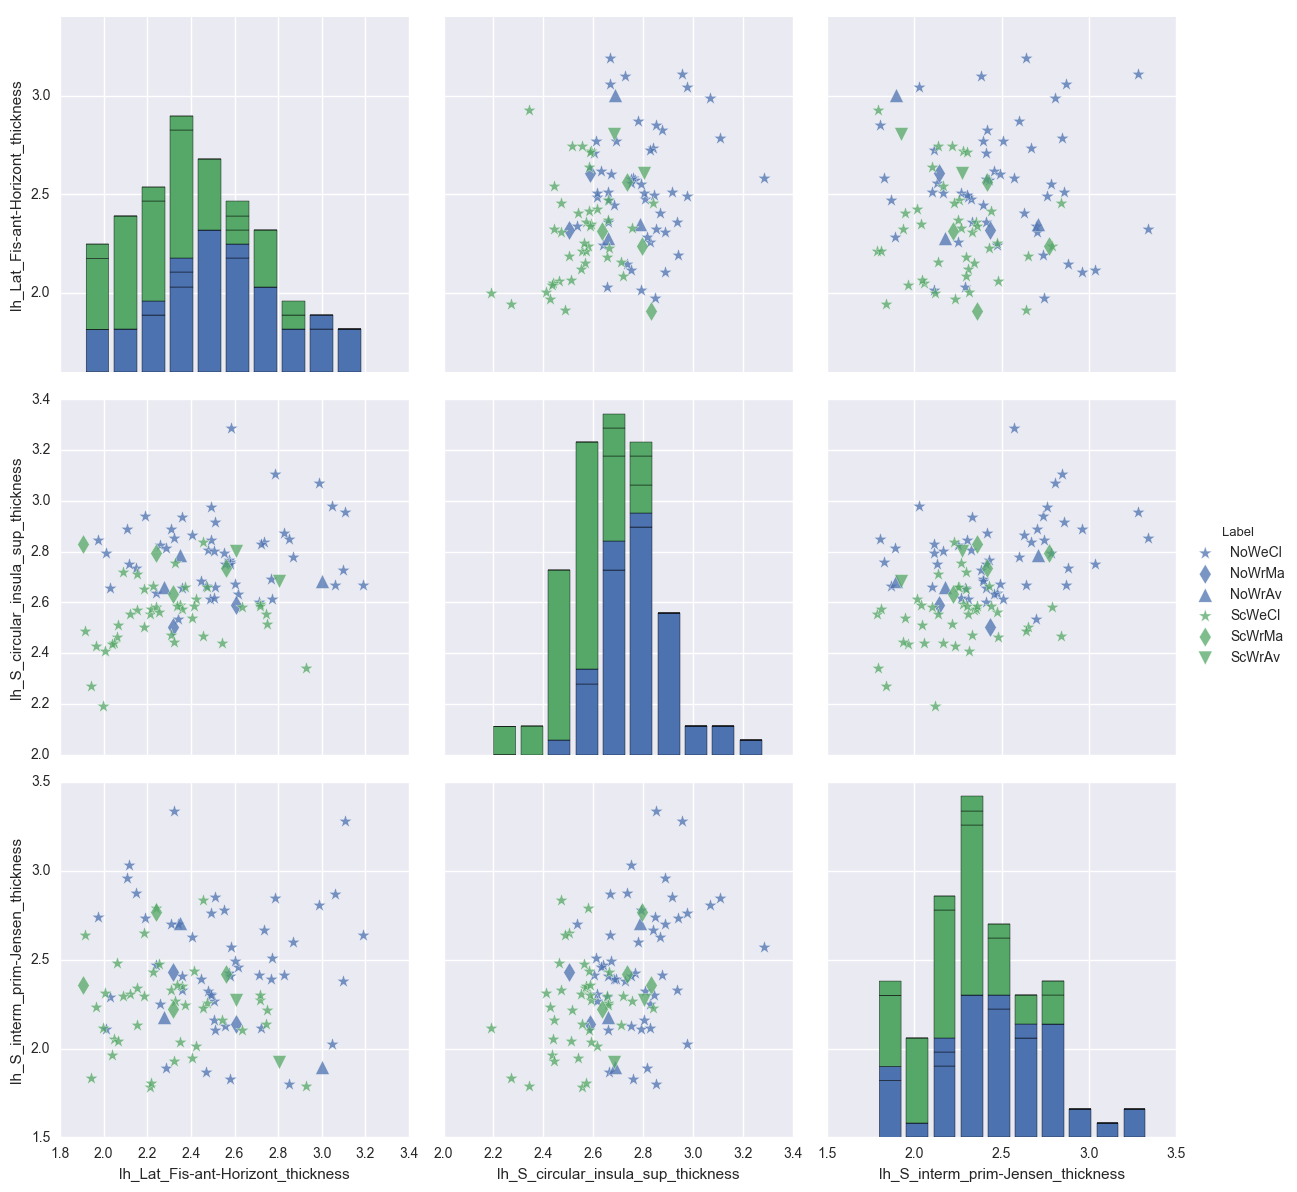



				 Pairplot for 3 best feature thickness in Yeo7Networks:




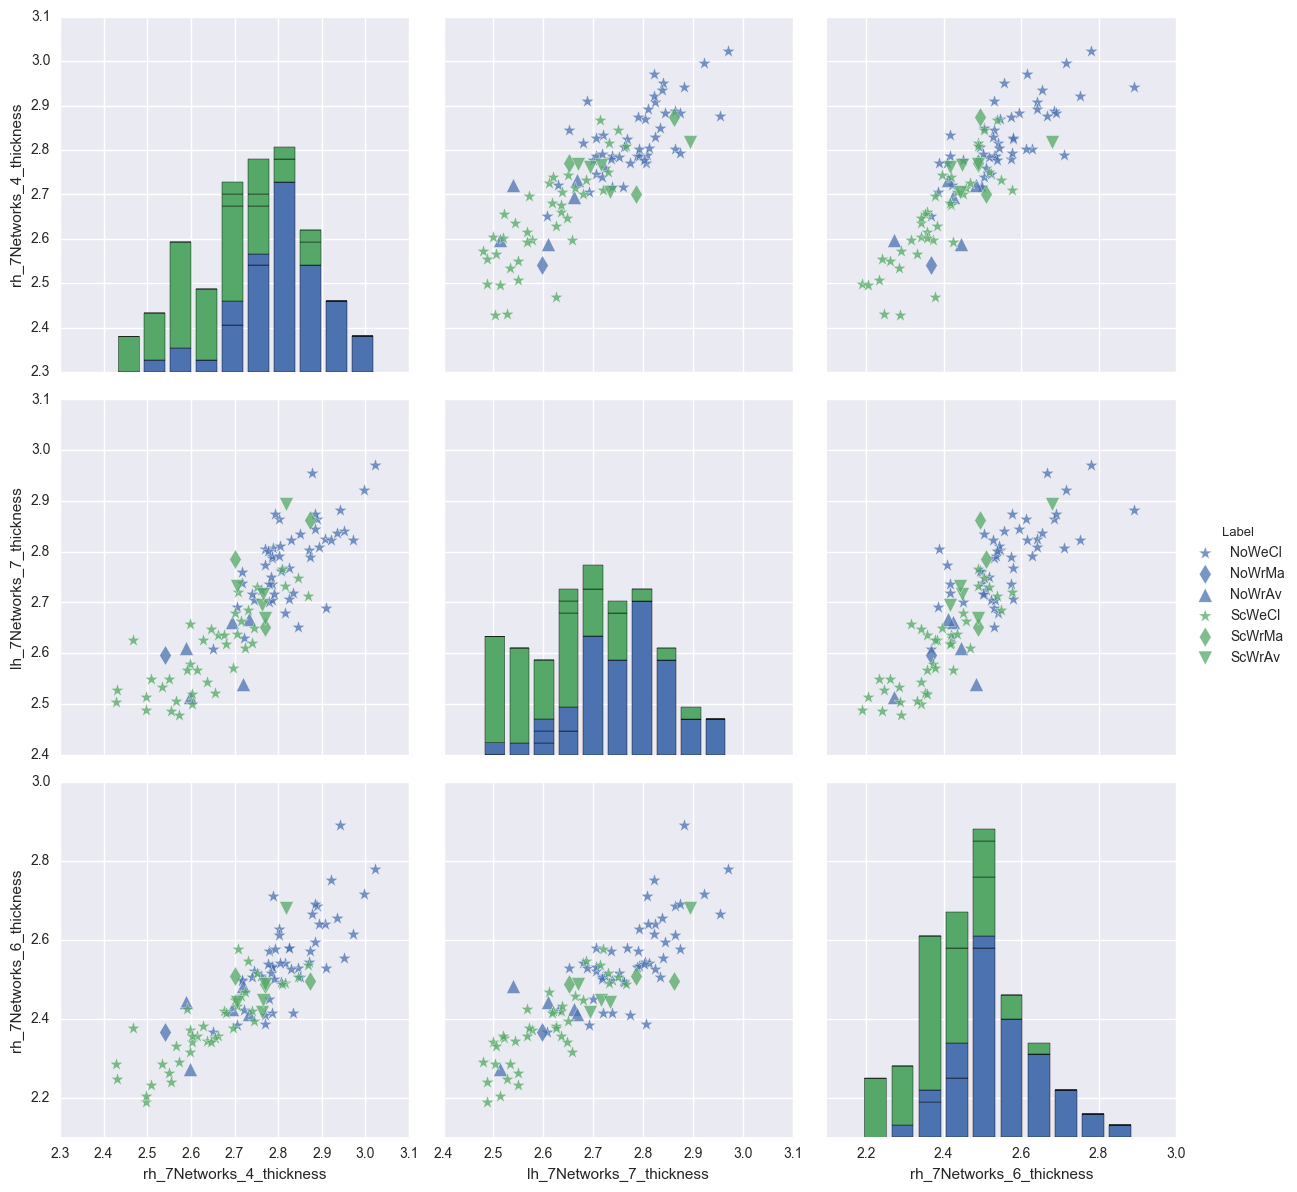



				 Pairplot for 3 best feature thickness in Yeo17Networks:




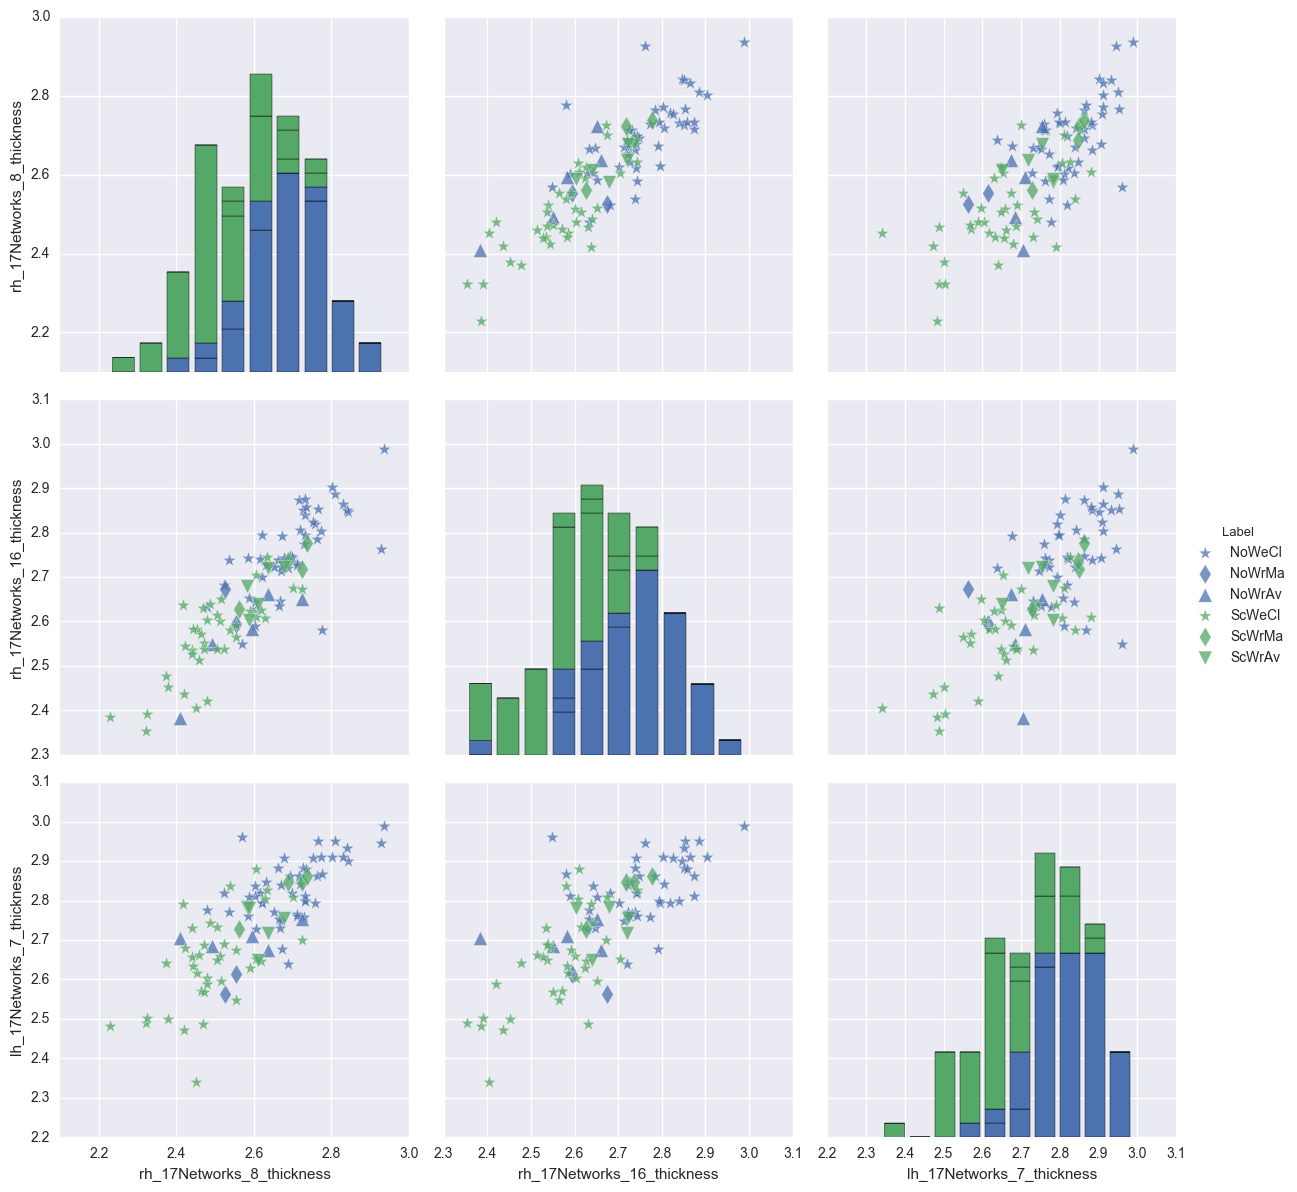

In [399]:
data_th = {}
features_to_plot_th = {}
print('Метки различны для различных атласов (для каждого атласа выделяются люди, которых мы не смогли классифицировать, обучаясь на данном атласе)')
for atlas in atlases:
    data_th[atlas] = X[atlas].copy()
    print('\n')
    print('\t\t\t\t Pairplot for 3 best feature thickness in {}:'.format(atlas))
    print('\n')
    features_to_plot_th[atlas] = df_coef_th_first_20[atlas].key.values[:3]
    data_th[atlas]['Label'] = label[atlas]
    
    g = sns.pairplot(data = data_th[atlas], hue = 'Label', vars = data_th[atlas][features_to_plot_th[atlas]], size = 4,
                     markers = ['*', 'd', '^', '*', 'd', 'v'], plot_kws = {'s': 100, 'alpha': 0.75}, 
                     palette=[colors[0]]*3+[colors[1]]*3)
    sns.plt.show()

## Отобразим данных людей в пространстве сниженной размерности, используя метод главных компонент 

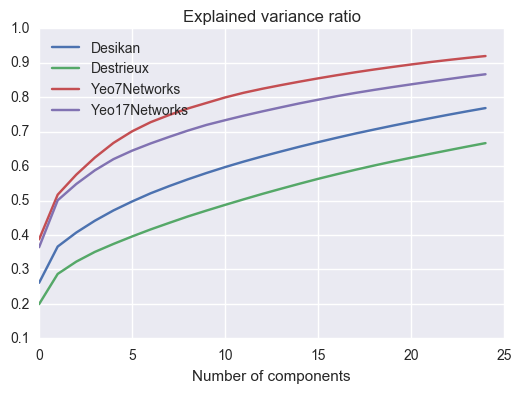

In [402]:
for atlas in atlases:
    pca = PCA(n_components = 25)
    pca.fit(X_scaled[atlas])
    plt.plot(np.cumsum(pca.explained_variance_ratio_), label = atlas)
    plt.legend(loc = 'upper left')
    plt.title('Explained variance ratio')
    plt.xlabel('Number of components')
    plt.grid(True)
plt.show()

### Оставим две компоненты

In [395]:
X_pca = {}
pca = {}
X_pca_df = {}
for atlas in atlases:
    pca[atlas] = PCA(n_components=2)
    X_pca[atlas] = pca[atlas].fit_transform(X_scaled[atlas])
    X_pca_df[atlas] = pd.DataFrame(data = X_pca[atlas], index = X[atlas].index)
    print('{:15s}: {}'.format(atlas, pca[atlas].explained_variance_ratio_)) 

Desikan        : [ 0.26121747  0.10524266]
Destrieux      : [ 0.19933441  0.08762507]
Yeo7Networks   : [ 0.38731661  0.12973997]
Yeo17Networks  : [ 0.3645044   0.13625785]


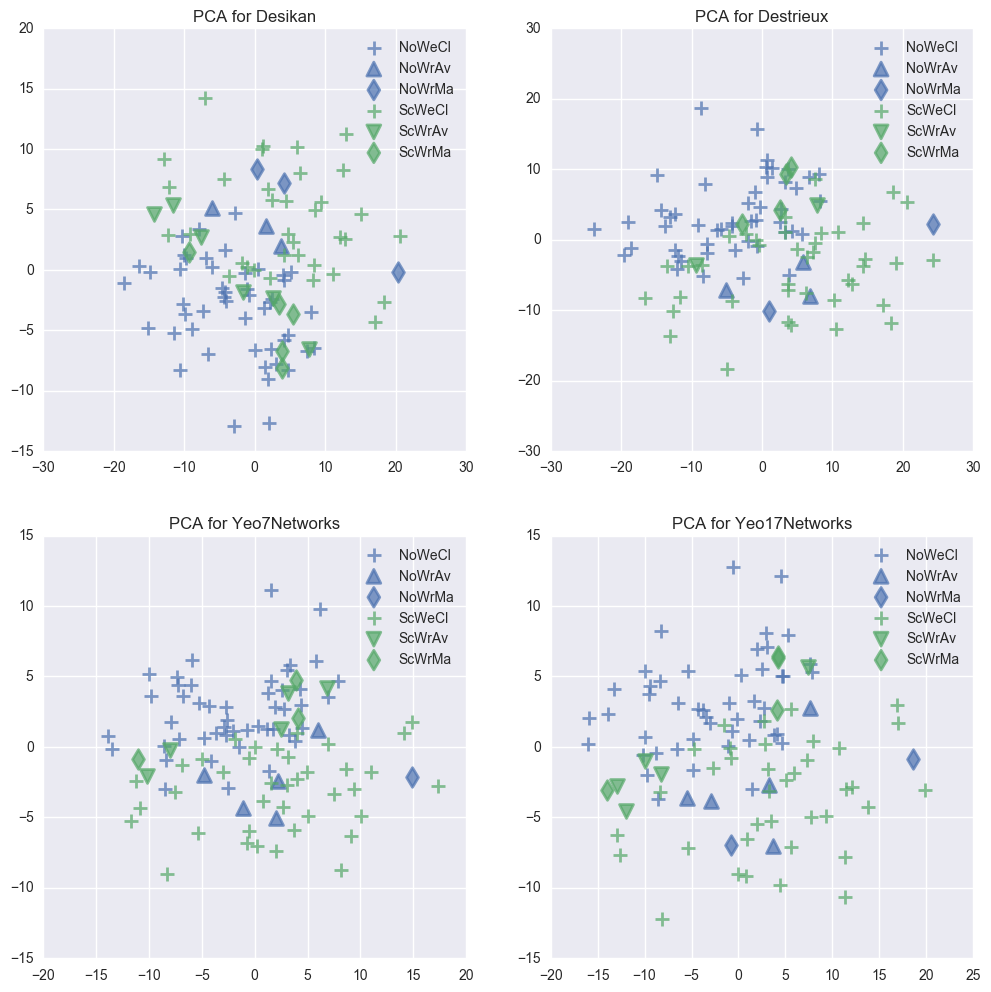

In [397]:
markers = ['+', '^', 'd', '+', 'v', 'd']
color = [colors[0]]*3+[colors[1]]*3
fig = plt.figure(figsize = (12,12))
for i, atlas in enumerate(atlases):
    X_pca_df[atlas]['label'] = label[atlas]
    ax = fig.add_subplot(2,2,1+i)
    for i, x in enumerate(X_pca_df[atlas].groupby('label')):
        ax.scatter(x[1][0],x[1][1], marker = markers[i], color = color[i], s = 100, alpha = 0.7, label = x[0], lw=2)
    ax.legend(loc = 'best')
    ax.set_title('PCA for {}'.format(atlas))

## Поиск сохранных зон

Поиск сохранных зон проводим с помощью видоизмененного Recursive Feature Selection, который на каждой итерации отбрасывает не наихудшие, а наилучшие с точки зрения классификации признаки. На каждом шаге будем отбрасывать по одному признаку и заканчиваем, когда остался лишь один наихудший признак. Такую операцию проводим несколько раз для каждого атласа, а затем усредняем полученные значения ранков для признаков. 

Таким образом, мы получаем таблицу $rank\_df[atlas]$, в которой для каждого из признаков указан его средний ранк, среднее отклонение и минимальный ранк по всем прогонам RFE (чем больше ранк, тем лучше признак разделяет классы).

Далее для первых $n$ признаков, где $n\in\{1\ldots 25\}$ оцениваем точность предсказания по кросс-валидации на всей выборке и получаем таблицу $score\_df[atlas]$   

In [14]:
from sklearn.feature_selection import RFE
import time

In [127]:
def make_rank_df(selector, random_states, atlas, feature_names):
    rank = []
    for rs in random_states:
        rank.append(selector[rs][atlas].ranking_)
    rank_mean = np.array(rank).mean(axis = 0)
    rank_std = np.array(rank).std(axis = 0)
    rank_min = np.array(rank).min(axis = 0)
    df = pd.DataFrame(data = [rank_mean, rank_std, rank_min], index = ['rank_mean','rank_std', 'rank_min'], 
                      columns = feature_names).transpose()
    df_sorted = df.sort_values(['rank_mean'], ascending=[True])
    return df_sorted

def get_cross_val_score(X, y, atlas, rank_df, sort_by, num_of_features, clf):
    scores_dict = evaluate_model(clf, X[atlas][rank_df[atlas].sort_values([sort_by]).iloc[:num_of_features, :].feature.values], y[atlas])
    return scores_dict

def make_rfe_analys_df(X, y, atlas, rank_df, sort_by, nums_of_features, 
                       clf = make_pipeline(StandardScaler(), LogisticRegressionCV(Cs = 30, cv = StratifiedKFold(n_splits=5, 
                                                                                                                shuffle=True), 
                                                                                  n_jobs = -1, scoring = 'accuracy')), 
                       verbose = 1):
    frames = []
    df_index = pd.MultiIndex.from_product([[atlas], ['accuracy', 'recall', 'specifity'], ['mean', 'std']])
    for num_of_features in nums_of_features:
        index = 'first {} features'.format(num_of_features) 
        scores, _ = get_cross_val_score(X, y, atlas, rank_df, sort_by, num_of_features, clf)
        frames.append(pd.DataFrame(data = [scores], columns = df_index, index =  [index]))
        if verbose == 1:
            hour = list(time.localtime())[3]
            minute = list(time.localtime())[4]
            sec = list(time.localtime())[5]
            print('Cross-validation in {}, number of features = {} have finished at {:02d}:{:02d}:{:02d}'.format(atlas, 
                                                                                                num_of_features, 
                                                                                                 hour, minute, sec))
    return pd.concat(frames)

In [ ]:
prime_numbers_big = [13, 17, 41, 43, 223, 227, 229, 233, 239, 593, 787, 1289, 2161, 2699, 3023, 3529]
selector = {}

for rs in prime_numbers_big:
    selector[rs] = {}
    for atlas in [desik, destr]:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = rs)
        clf = make_pipeline(StandardScaler(), LogisticRegressionCV(Cs = 20, cv = cv, n_jobs = -1, scoring = 'accuracy'))
        selector[rs][atlas] = RFE(clf, n_features_to_select = 1, step = 1)
        selector[rs][atlas] = selector[rs][atlas].fit(X[atlas][thickness_idx[atlas]], y[atlas])
    hour = list(time.localtime())[3]
    minute = list(time.localtime())[4]
    sec = list(time.localtime())[5]
    print('Iteration with random state = {} have finished at {:02d}:{:02d}:{:02d} '.format(rs, hour, minute, sec))

rank_df = {}
for atlas in [desik, destr]:
    rank_df[atlas] = make_rank_df(selector, prime_numbers_big, atlas, thickness_idx[atlas])
    rank_df[atlas]['feature'] = rank_df[atlas].index
    rank_df[atlas].index = np.arange(1, len(thickness_idx[atlas])+1)
    rank_df[atlas].to_csv('rank_df_'+atlas+'.csv')

### Построим графики точности предсказания на кросс-валидации от количества первых признаков

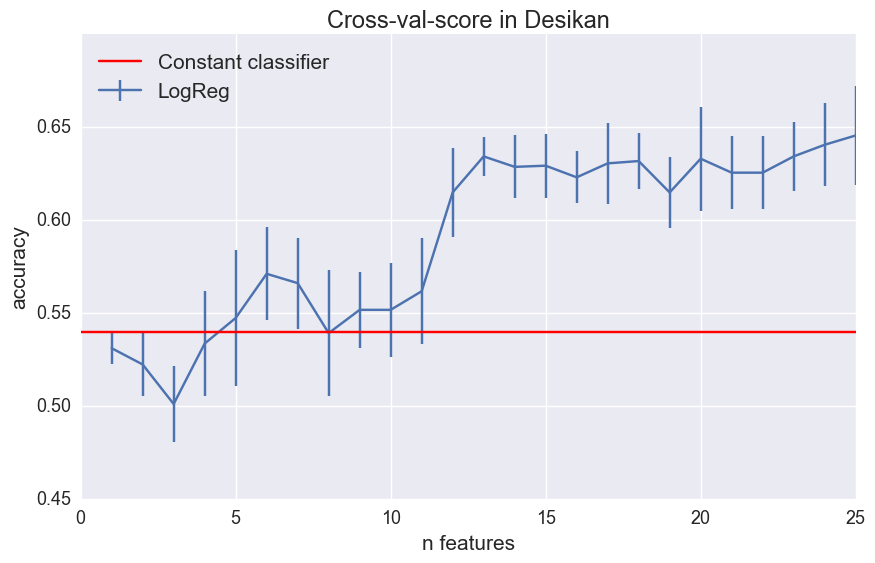

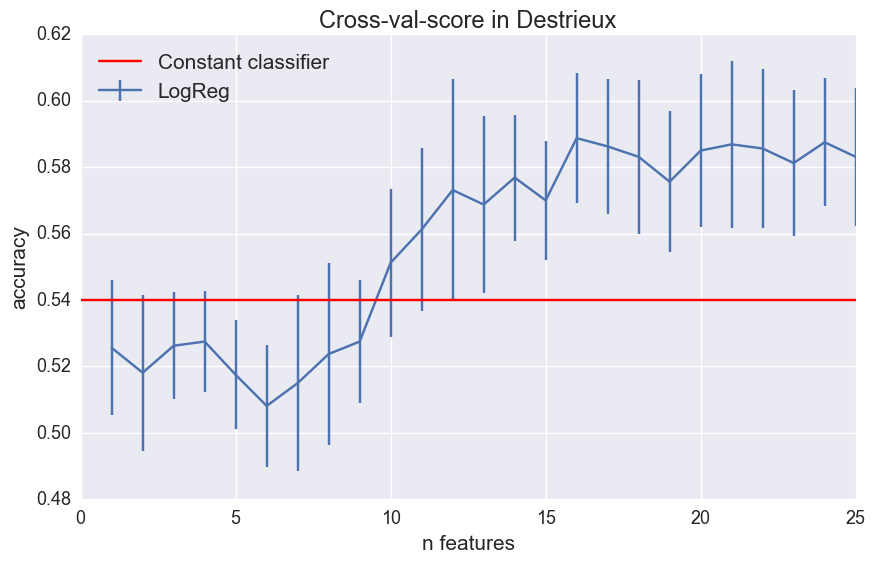

In [59]:
for atlas in [desik, destr]:  
    fig = plt.figure(figsize = (10,6))
    plt.errorbar(np.arange(1,26),score_df[atlas][[(atlas, 'accuracy', 'mean')]].values.ravel(), 
             yerr = score_df[atlas][[(atlas, 'accuracy', 'std')]].values.ravel(), label = 'LogReg')
    plt.plot(np.linspace(0,25),50*[0.54], color = 'red', label = 'Constant classifier')
    plt.title('Cross-val-score in {}'.format(atlas), fontsize = 17)
    plt.xlabel('n features', fontsize = 15)
    plt.ylabel('accuracy', fontsize = 15)
    plt.legend(loc = 'upper left', fontsize = 15)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.show()

#### Итак, предварительный анализ показывает, что по первым 11 наихудшим признакам для атласа Desikan и 12 для атласа Destrieux мы можем классифицировать людей с заболеванием не лучше, чем константный классификатор. 

#### Но возможно, что этот список признаков можно будет дополнить, так как массивы признаков отсортированные по среднему ранку и по минимальному не совпадают (например есть признаки со средним ранком порядка 100, а минимальным порядка 3). Такие нужно будет исследовать дополнительно.

In [63]:
mindex = pd.MultiIndex.from_product([[desik, destr], ['feature', 'rank_mean', 'rank_std', 'rank_min']])
pd.DataFrame(data = np.hstack((rank_df[desik][:12][['feature', 'rank_mean', 'rank_std', 'rank_min']].values, 
                               rank_df[destr][:12][['feature', 'rank_mean', 'rank_std', 'rank_min']].values)), 
             columns = mindex)

Desikan                               \
                                  feature rank_mean  rank_std rank_min   
0                 rh_entorhinal_thickness         1         0        1   
1            rh_parahippocampal_thickness         2         0        2   
2               rh_temporalpole_thickness    3.4375  0.998045        3   
3           rh_isthmuscingulate_thickness    3.8125  0.390312        3   
4              lh_pericalcarine_thickness    5.6875  0.681795        4   
5              rh_pericalcarine_thickness    6.6875  0.681795        5   
6   rh_rostralanteriorcingulate_thickness         8       0.5        7   
7                 lh_entorhinal_thickness     8.625  0.599479        7   
8            lh_parahippocampal_thickness   10.3125   0.91643        9   
9                rh_frontalpole_thickness      10.5  0.612372        9   
10              lh_temporalpole_thickness    11.625  0.484123       11   
11          lh_isthmuscingulate_thickness        13  0.612372       12   

                             Destrieux                               
                               feature rank_mean  rank_std rank_min  
0           rh_G_subcallosal_thickness      1.75  0.433013        1  
1          rh_S_pericallosal_thickness    3.0625  0.747391        2  
2   lh_G_cingul-Post-ventral_thickness    4.0625  0.747391        3  
3         lh_G_insular_short_thickness    5.0625  0.747391        4  
4    lh_S_orbital_med-olfact_thickness     6.875  0.992157        5  
5            lh_G_precentral_thickness     7.875  0.992157        6  
6   rh_G_oc-temp_med-Parahip_thickness     8.625   5.10973        5  
7         rh_S_occipital_ant_thickness   10.6875   2.31081        7  
8     lh_G_and_S_paracentral_thickness   11.8125   2.53029        8  
9    lh_Lat_Fis-ant-Vertical_thickness   11.8125   1.58976        9  
10  lh_G_and_S_occipital_inf_thickness    13.375   2.86956        9  
11        rh_G_occipital_sup_thickness      14.5   2.76134       10

In [76]:
rank_df[desik]

,rank_mean,rank_std,rank_min,feature
1,1.0000,0.000000,1.0,rh_entorhinal_thickness
2,2.0000,0.000000,2.0,rh_parahippocampal_thickness
3,3.4375,0.998045,3.0,rh_temporalpole_thickness
4,3.8125,0.390312,3.0,rh_isthmuscingulate_thickness
5,5.6875,0.681795,4.0,lh_pericalcarine_thickness
6,6.6875,0.681795,5.0,rh_pericalcarine_thickness
7,8.0000,0.500000,7.0,rh_rostralanteriorcingulate_thickness
8,8.6250,0.599479,7.0,lh_entorhinal_thickness
9,10.3125,0.916430,9.0,lh_parahippocampal_thickness
10,10.5000,0.612372,9.0,rh_frontalpole_thickness


Pairplot for 3 worst features thickness in Desikan:


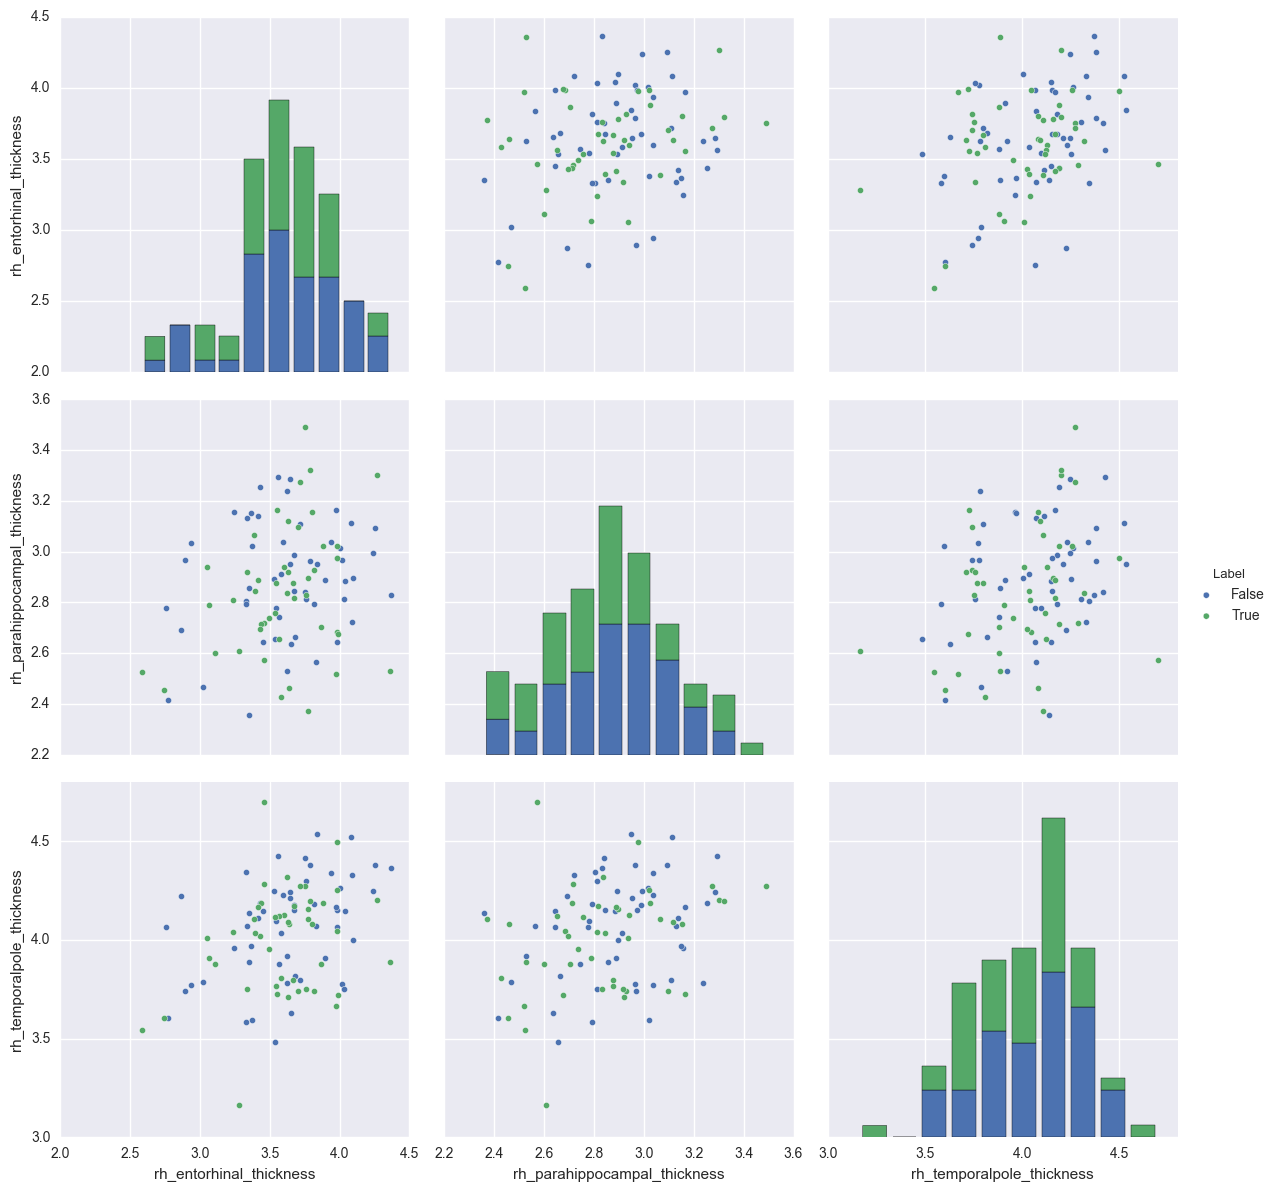

Pairplot for 3 worst features thickness in Destrieux:


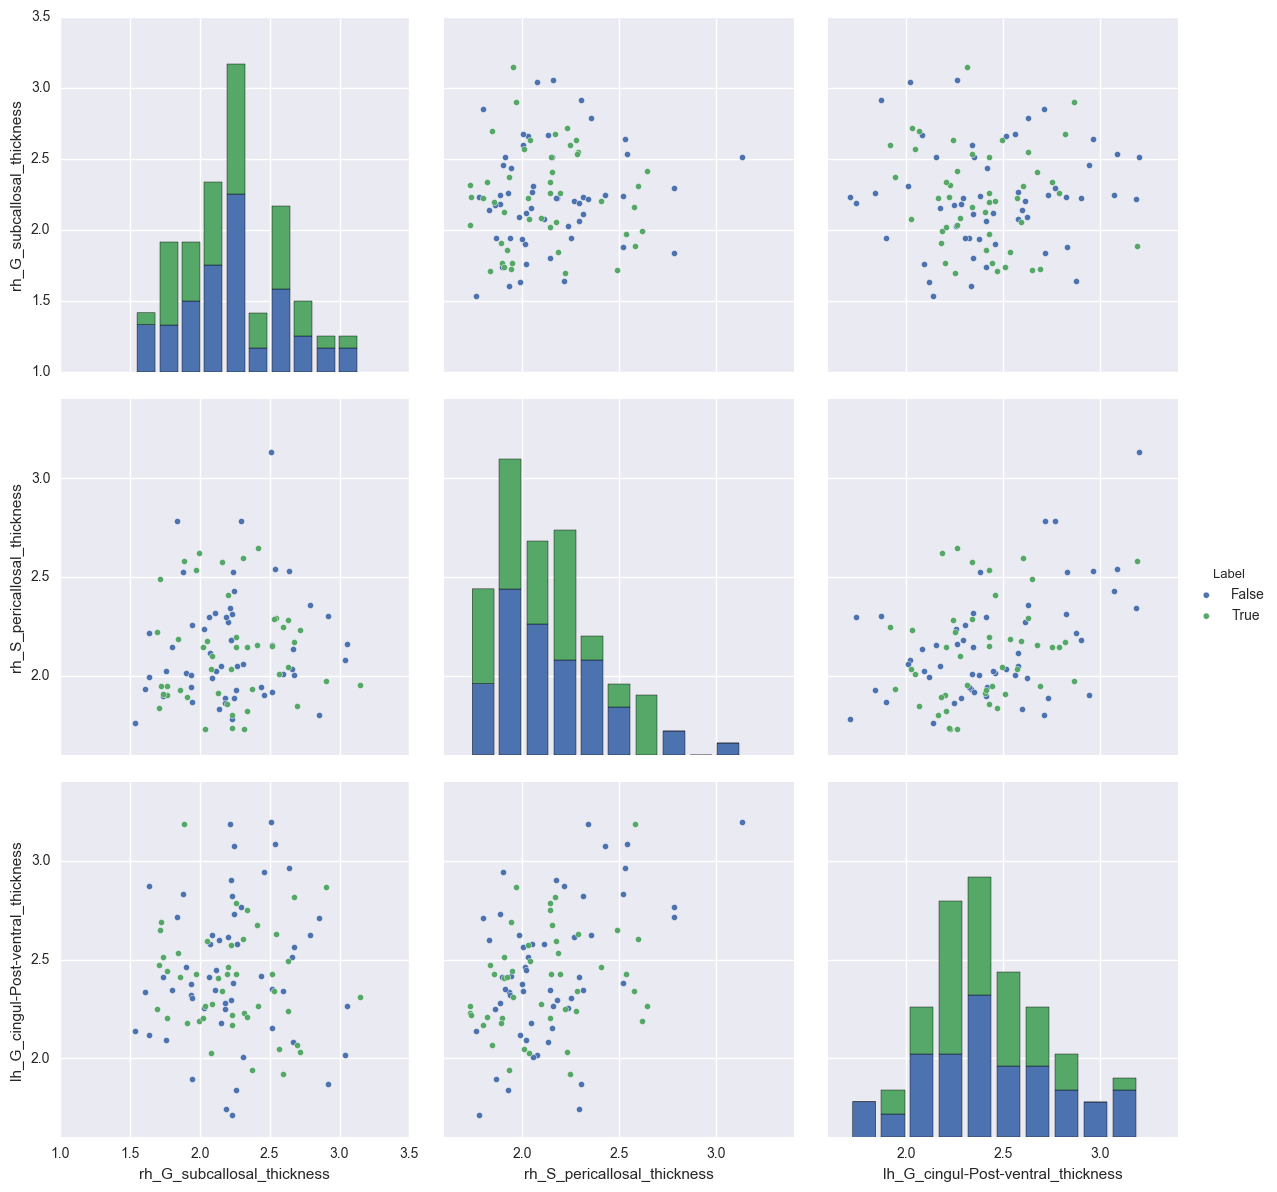

In [133]:
data_bad = {}
features_to_plot_bad = {}
for atlas in [desik, destr]:
    data_bad[atlas] = X[atlas].copy()
    print('Pairplot for 3 worst features thickness in {}:'.format(atlas))
    features_to_plot_bad[atlas] = rank_df[atlas].feature.values[:3]
    data_bad[atlas]['Label'] = y[atlas]
    sns.pairplot(data = data_bad[atlas], hue = 'Label', vars = data_bad[atlas][features_to_plot_bad[atlas]], size = 4)
    sns.plt.show()

In [75]:
bound = 12
rank_df[destr][np.array(rank_df[destr].index > bound)*np.array(rank_df[destr].rank_min <= bound)]

,rank_mean,rank_std,rank_min,feature
13,16.0000,3.162278,11.0,lh_Pole_occipital_thickness
14,16.9375,2.967928,12.0,lh_S_central_thickness
15,17.1875,6.663508,8.0,lh_S_pericallosal_thickness
16,17.5000,2.397916,12.0,lh_G_cuneus_thickness
17,18.6875,4.482170,10.0,rh_G_rectus_thickness
22,21.6875,6.807337,9.0,lh_G_temp_sup-Plan_polar_thickness
23,23.1875,6.095272,11.0,lh_G_Ins_lg_and_S_cent_ins_thickness
25,24.8750,42.300820,1.0,rh_G_cingul-Post-ventral_thickness
92,90.3750,62.607782,9.0,rh_G_temp_sup-G_T_transv_thickness
101,98.6250,64.503755,3.0,rh_G_Ins_lg_and_S_cent_ins_thickness


In [74]:
bound = 12
rank_df[desik][np.array(rank_df[desik].index > bound)*np.array(rank_df[desik].rank_min <= bound)]

,rank_mean,rank_std,rank_min,feature
16,16.4375,23.840535,5.0,rh_transversetemporal_thickness


In [ ]:
score_df = {}
nums_of_features = np.arange(1,30)
cv = StratifiedKFold(n_splits=5, shuffle=True)
knn_dict = {'n_neighbors': np.arange(2,10), 'weights': ['uniform', 'distance']}
C_range = np.logspace(-5, 5, 21)
gamma_range = np.logspace(-13, 4, 17)
svc_dict = dict(gamma=gamma_range, C=C_range)

clf_logreg = make_pipeline(StandardScaler(), LogisticRegressionCV(Cs = 30, cv = cv, n_jobs = -1, scoring = 'accuracy'))
clf_knn = make_pipeline(StandardScaler(), GridSearchCV(KNN(), knn_dict, scoring = 'accuracy', n_jobs=-1, cv = cv))
clf_SVC = make_pipeline(StandardScaler(), GridSearchCV(SVC(), param_grid=svc_dict, scoring= "accuracy", cv=cv, n_jobs=-1))
clf_range = [clf_logreg, clf_knn, clf_SVC]
clf_names = ['LogReg', 'KNN', 'SVC']
for atlas in [desik, destr]:
    score_df[atlas] = {}
    for i, clf in enumerate(clf_range):
        score_df[atlas][clf_names[i]] = make_rfe_analys_df(X, y, atlas, rank_df, 'rank_mean', nums_of_features, clf)
        score_df[atlas][clf_names[i]].to_csv('score_df_'+atlas+'_'+clf_names[i]+'.csv')